In [348]:
import numpy as np
import matplotlib.pyplot as plt

#This file does not have all the tests on purpose

#Set Parameters
n = 7
k_o = .1
k_s = 1
alpha = 1 - (2 * (k_o/k_s))
alpha_prime = k_o/k_s
p = 5
q = 3
c_var = 0
lamb_val = np.arccosh((1+c_var)/(1-alpha))

def set_parameters(n_val, k_o_val, k_s_val, p_val, q_val, c_var_val):
    global n, k_o, k_s, alpha, alpha_prime, p, q, c_var, lamb_val
    # Set variables globally
    n = n_val
    k_o = k_o_val
    k_s = k_s_val
    alpha = 1 - (2 * (k_o / k_s))
    alpha_prime = k_o / k_s
    p = p_val
    q = q_val
    c_var = c_var_val
    # lamb_val depends on the other variables
    lamb_val = np.arccosh((1 + c_var) / (1 - alpha))

K = {}
K_exp = {}
A = {}

arr_len = n-1
dual_len = (n-1) * 2
dual_len_exp = (n-1)*2 + 2
a = np.zeros(dual_len)
a_exp = np.zeros(dual_len_exp)
b = np.zeros(arr_len)
b_bar = np.zeros(arr_len)
c = np.zeros(1)
c_bar = np.zeros(1) 

In [349]:
def check_variables():
    print('n: ', n)
    print('alpha: ', alpha)
    print('k_s: ', k_s)
    print('k_o: ', k_o)
    print('alpha_prime: ', alpha_prime)
    print('c_var', c_var)
    print('lamb_val', lamb_val)
    print('a', a)
    print('a_exp', a_exp)
    print('b', b)
    print('c', c)

#K matrix without exceptions
    # return_k = false -> returns offset diagonal  
def tridiag(n):
    arr_len = n-1
    diag_len = arr_len-1
    B = np.diag(np.ones((diag_len)), k=1) + np.diag(np.ones((diag_len)), k=-1)
    return B        

def k_create(n, alpha_prime):
    arr_len = n-1
    A = np.identity(arr_len)
    D = A
    B = alpha_prime*tridiag(n)
    C = B
    E = np.block([[A,B],[B,A]])
    return E

def y_create(n):
    A = np.ones(n-1)
    B = A * -1
    D = np.concatenate([A, B])
    return D

def a_create(n, alpha_prime):
    K = k_create(n, alpha_prime)
    y = y_create(n)
    a = np.linalg.solve(K, y)
    return a

K = k_create(n,alpha_prime)
# print('K', '\n', K)
# print('det:', np.linalg.det(K))

y = y_create(n)
a = a_create(n, alpha_prime)

#creates a vector for exceptions (only works for exception cases!)
def e_i(n, i):
    len_arr = n-1
    array_pos = i-1     #(-1 to normalize), p and q refer to normal indices (from 1 to len_arr)
    arr = np.zeros(len_arr)
    if i > 0 and i < n: #if outside, k_o excluded from similarity matrix e.g. AE exception for n=5
        arr[array_pos] = 1 
    return arr

#sides matrix in k_exp representing exceptions
def k_exp_horiz(n, p, q, alpha_prime):
    A = e_i(n, p) + e_i(n, q-1)
    B = e_i(n, q) + e_i(n, p-1)
    C = e_i(n, p-1) + e_i(n, q)
    D = e_i(n, q-1) + e_i(n, p)
    E = alpha_prime * np.block([[A,C],[B,D]])
    return E

def k_create_excep(n, p, q, alpha_prime):
    K = k_create(n, alpha_prime)
    E_1 = k_exp_horiz(n, p, q, alpha_prime)
    E_2 = E_1.transpose()
    E_3 = np.identity(2) #2 since there's only 2 columns for exceptions
    
    W = np.concatenate([K, E_1])
    X = np.concatenate([E_2, E_3])
    Z = np.concatenate([W, X], 1)
    return Z

def y_create_exp(n):
    A = np.ones(n-1)
    B = A * -1
    C = np.array([1, -1])
    D = np.concatenate([A, B, C])
    return D

def a_exp_create(n, p, q, alpha_prime):
    K_exp = k_create_excep(n, p, q, alpha_prime)
    y_exp = y_create_exp(n)
    a_exp = np.linalg.solve(K_exp, y_exp)
    return a_exp

K_exp = k_create_excep(n, p, q, alpha_prime)
y_exp = y_create_exp(n)
a_exp = a_exp_create(n, p, q, alpha_prime)

# Create a dictionary with keys generated using the index and values from the array
def create_bc(n,p,q,alpha_prime):
    a_exp = a_exp_create(n,p,q,alpha_prime)
    num_coeff = n-1
    b = {i: a_exp[i-1] for i in range(1, num_coeff + 1)}
    b_bar = {i: a_exp[i-1+n-1] for i in range(1, num_coeff + 1)}
    c = {1: a_exp[2 * num_coeff]}
    c_bar = {1: a_exp[2 * num_coeff + 1]}
    return b, b_bar, c, c_bar

def create_bc_arrays(n,p,q,alpha_prime):
    b, b_bar, c, c_bar = create_bc(n,p,q,alpha_prime)
    b_array = dict_to_array(b)
    b_bar_array = dict_to_array(b_bar)
    c_array = dict_to_array(c)
    c_bar_array = dict_to_array(c_bar)
    return b_array, b_bar_array, c_array, c_bar_array

def get_b(i):
    b, b_bar, c, c_bar = create_bc(n,p,q,alpha_prime)
    if i < 1 or i >= n:
        return 0
    else:
        return b[i]

#turns dictionary to array for testing
def dict_to_array(dict_arr):
    arr = np.zeros(len(dict_arr))
    for i in range(1, len(dict_arr) + 1):
       arr[(i-1)] = dict_arr[i]  
    return arr        

b, b_bar, c, c_bar = create_bc(n,p,q,alpha_prime)
b_array, b_bar_array, c_array, c_bar_array = create_bc_arrays(n,p,q,alpha_prime)

A = tridiag(n)
B = np.linalg.inv(np.identity(n-1) - (A*alpha_prime))

def B_ij_analytical(i, j):
    num = np.cosh((n-(np.abs(j-i))) * lamb_val) - np.cosh((n-i-j)*lamb_val)
    denom = (1-alpha) * np.sinh(lamb_val) * np.sinh(n * lamb_val)
    return num/denom

def B_ij(i,j):
    i_ind = i-1
    j_ind = j-1
    if i < 1 or j < 1 or i > n or j > n:
        return 0
    else: 
        return B[i_ind][j_ind]

#test analytical solutions for b and c
def b_exist(b, i):
    if i>0 and i<n: 
        return b[i]
    else: 
        return 0

def b_mult():
    A = tridiag(n)
    B = np.linalg.inv(np.identity(n-1) - (A*alpha_prime))

    K_mult = np.ones(n-1) - (c[1]*alpha_prime*(e_i(n, p) + e_i(n, q-1) - e_i(n, p-1) - e_i(n, q)))
    b_exp_analytical = B @ K_mult
    return b_exp_analytical

def b_til_dict():
    b_til = B @ np.ones(len(B))
    b_til_dict = {i: b_til[i-1] for i in range(1, arr_len + 1)}
    return b_til_dict

def b_i(i):
    if i < 1 or i > arr_len:
        return 0
    else:
        return b[i]

def K_row(j, k):
    arr_1 = np.zeros(n-1)
    for i in range (0, n-1):
        if j == (i+1) and k == (i+2):
            arr_1[i] = 1
            break
        if j == (i+1):
            arr_1[i] = alpha_prime
        if k == (i+2):
            arr_1[i] = alpha_prime
    arr_2 = np.zeros(n-1)
    for i in range (0, n-1):
        if j == (i+2) and k == (i+1):
            arr_2[i] = 1
            break
        if j == (i+2):
            arr_2[i] = alpha_prime
        if k == (i+1):
            arr_2[i] = alpha_prime
    
    return np.concatenate([arr_1, arr_2])

def K_row_exp(j, k):
    arr_1 = np.zeros(n-1)
    for i in range (0, n-1):
        if j == (i+1) and k == (i+2):
            arr_1[i] = 1
            break
        if j == (i+1):
            arr_1[i] = alpha_prime
        if k == (i+2):
            arr_1[i] = alpha_prime
    arr_2 = np.zeros(n-1)
    for i in range (0, n-1):
        if j == (i+2) and k == (i+1):
            arr_2[i] = 1
            break
        if j == (i+2):
            arr_2[i] = alpha_prime
        if k == (i+1):
            arr_2[i] = alpha_prime
    arr_3 = np.zeros(2)
    if j == p and k == q:
        arr_3[0] = 1
    elif j == q and k == p:
        arr_3[1] = 1 
    elif j == p or k == q:
        arr_3[0] = alpha_prime
    elif j == q or k == p:
        arr_3[1] = alpha_prime
    
    return np.concatenate([arr_1, arr_2, arr_3])

def delta(i,j):
    if i == j:
        return 1
    else:
        return 0

def f_j_k(j,k):
    K_row_exp_cur = K_row_exp(j,k)
    return K_row_exp_cur@a_exp
    
def rank_mult_exp(j):
    rank = alpha_prime * (b_i(j-1) - b_i(j) + c[1] * (delta(j,q) - delta(j,p)))
    return rank

def show_ranks_exp():
    for i in range (1, n):
        print(f'{i}:', rank_mult_exp(i)) 
                
show_ranks_exp()

#returns B_ij
def create_B_ij_exp(i,j):
    num = np.sinh((n-np.max([i,j]))*lamb_val) * np.sinh(np.min([i,j]) * lamb_val)
    denom = np.sinh(lamb_val) * np.sinh(n*lamb_val)
    return num/denom/alpha_prime

def B_ij(i,j):
    if i > 0 and i <= n and j > 0 and j <= n:
        return create_B_ij_exp(i,j)
    else:
        return 0
    
def create_D_ij_exp(i, j):
    return alpha_prime * ( create_B_ij_exp(i-1, j) 
                          + create_B_ij_exp(i, j-1) 
                          - create_B_ij_exp(i, j) 
                          - create_B_ij_exp(i-1, j-1))

def D_ij(i,j):
    if i > 0 and i <= n and j > 0 and j <= n:
        return create_D_ij_exp(i,j)
    else:
        return 0

def create_D_ij_matrix():
    arr = np.zeros((n,n))
    for i_ind in range (0, n):
        i = i_ind + 1
        for j_ind in range (0, n):
            j = j_ind + 1
            arr[i_ind][j_ind] = create_D_ij_exp(i, j)
    return arr

#i <= j-1
def D_ij_analytical_case_1(i, j):
    l = lamb_val
    one = np.sinh((n-j)*l)
    two = np.sinh(i*l)
    three = np.sinh((i-1)*l)
    four = np.sinh((n-(j-1))*l)
    num = (one * three) + (four * two) - (one * two) - (four * three)
    denom = np.sinh(lamb_val) * np.sinh(lamb_val * n)
    return num/denom

def D_ij_analytical_case_2(i, j):
    l = lamb_val
    one = np.sinh((n-i)*l)
    two = np.sinh(j*l)
    three = np.sinh((j-1)*l)
    four = np.sinh((n-(i-1))*l)
    num = (one * three) + (four * two) - (one * two) - (four * three)
    denom = np.sinh(lamb_val) * np.sinh(lamb_val * n)
    return num/denom

def create_D_ij_analytical_1_case_3a(i, j):
    l = lamb_val
    one = np.sinh((n - max(i-1,j))*l) * np.sinh(min(i-1,j)*l)
    two = np.sinh((n - max(i,j-1))*l) * np.sinh(min(i,j-1)*l)
    three = np.sinh(((n-max(i,j)))*l) * np.sinh((min(i,j))*l)
    four = np.sinh((n-max(i-1,j-1))*l) * np.sinh(min(i-1,j-1)*l)
    num = one + two - three - four
    denom = np.sinh(lamb_val) * np.sinh(lamb_val * n)
    return num/denom

def D_ij_analytical_case_3b(i, j):
    l = lamb_val
    one = np.sinh((n-j)*l) * np.sinh((i-1)*l)
    two = np.sinh((n-i)*l) * np.sinh((j-1)*l)
    three = np.sinh((n-i)*l) * np.sinh((i)*l)
    four = np.sinh((n-(i-1))*l) * np.sinh((j-1)*l)
    num = one + two - three - four
    denom = np.sinh(lamb_val) * np.sinh(lamb_val * n)
    return num/denom

def D_ij_analytical_sol(i, j):
        if i < j:
            return D_ij_analytical_case_1(i, j)
        elif i > j: 
            return D_ij_analytical_case_2(i, j)
        elif i == j:
            return create_D_ij_analytical_1_case_3a(i, j)

#nonexception
def rank(i):
    num = np.sinh(( ((n+1)/2) - i) * lamb_val)
    denom = np.sinh(((n+1)/2) * lamb_val) - np.sinh(((n-1)/2) * lamb_val)
    return num / denom

def rank_til(i):
    return -rank(i)

def rank_mult_exp_2(j):
    rank_mult_exp_2 = rank_til(j) + ( c[1] * 
                                     alpha_prime * (D_ij(j,q) - D_ij(j,p) + delta(j,q) - delta(j,p)) )
    return rank_mult_exp_2

def c_double_til():
    num = 1 + rank_til(p) - rank_til(q)
    denom = 1 - (alpha_prime * (D_ij_analytical_sol(p,q) - D_ij_analytical_sol(p,p) - D_ij_analytical_sol(q,q) + D_ij_analytical_sol(q,p)) ) 
    c_analytical = num/denom
    return c_analytical

def c_analytical_form():
    c_analytical = c_double_til()
    return c_analytical

def rank_mult_exp_analytical(j):
    rank = rank_til(j) + c_analytical_form() * alpha_prime * (D_ij_analytical_sol(j, q) - D_ij_analytical_sol(j, p) + delta(j,q) - delta(j,p))
    return rank

assert np.isclose(c_analytical_form(), c[1])

1: -0.11142587346553352
2: -0.0028328611898017055
3: 0.08309726156751657
4: 0.0
5: -0.08309726156751657
6: 0.0028328611898017055


In [350]:
check_variables()

n:  7
alpha:  0.8
k_s:  1
k_o:  0.1
alpha_prime:  0.1
c_var 0
lamb_val 2.2924316695611777
a [ 1.12372304  1.23723042  1.24858116  1.24858116  1.23723042  1.12372304
 -1.12372304 -1.23723042 -1.24858116 -1.24858116 -1.23723042 -1.12372304]
a_exp [ 1.11425873  1.14258735  1.35387158  1.35387158  1.14258735  1.11425873
 -1.11425873 -1.14258735 -1.35387158 -1.35387158 -1.14258735 -1.11425873
  1.04225685 -1.04225685]
b {1: 1.1142587346553352, 2: 1.1425873465533523, 3: 1.3538715769593956, 4: 1.3538715769593956, 5: 1.1425873465533523, 6: 1.1142587346553352}
c {1: 1.042256846081209}


In [351]:
# set_parameters(n_val = 9, k_o_val = .40, k_s_val = 1, p_val = 6, q_val = 4, c_var_val = 0)

n:  7
alpha:  0.8
k_s:  1
k_o:  0.1
alpha_prime:  0.1
c_var 0
lamb_val 2.2924316695611777
a [ 1.12372304  1.23723042  1.24858116  1.24858116  1.23723042  1.12372304
 -1.12372304 -1.23723042 -1.24858116 -1.24858116 -1.23723042 -1.12372304]
a_exp [ 1.11425873  1.14258735  1.35387158  1.35387158  1.14258735  1.11425873
 -1.11425873 -1.14258735 -1.35387158 -1.35387158 -1.14258735 -1.11425873
  1.04225685 -1.04225685]
b {1: 1.1142587346553352, 2: 1.1425873465533523, 3: 1.3538715769593956, 4: 1.3538715769593956, 5: 1.1425873465533523, 6: 1.1142587346553352}
c {1: 1.042256846081209}
check_ranks
rank:  0.11237230419977298 rank_mult 0.11237230419977297
rank:  0.011350737797956865 rank_mult 0.011350737797956853
rank:  0.0011350737797956867 rank_mult 0.001135073779795692
rank:  0.0 rank_mult 0.0
rank:  -0.0011350737797956867 rank_mult -0.001135073779795692
rank:  -0.011350737797956865 rank_mult -0.011350737797956853
rank:  -0.11237230419977298 rank_mult -0.11237230419977297
ranks are correct
0.11

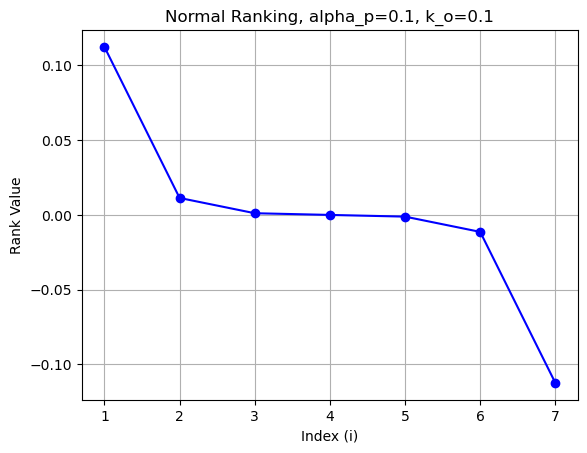

In [352]:
#Non Exception Ranking

import numpy as np
#non adjacent test cases

#rank with indices

def rank_mult(k_s, alpha, a, n, j):
    ind = j-1
    if j == 1:
        return k_s * ((1-alpha)/2) * (a[ind])
    elif j > 1 and j < n:
        return k_s * ((1-alpha)/2) * (a[ind] - a[ind-1])
    elif j == n:
        return k_s * ((1-alpha)/2) * (-a[ind-1])
    else:
            print('j index error')

#confirm 
def check_ranks(k_s, alpha, a, n):
    print('check_ranks')
    for j in range (1, n+1):
        rank_val = rank(j)
        rank_mult_val = rank_mult(k_s, alpha, a, n, j)
        print('rank: ', rank_val, 'rank_mult', rank_mult_val)    
        
        assert np.isclose(rank_val, rank_mult_val)   
    print('ranks are correct')
    
check_variables()
check_ranks(k_s, alpha, a, n)

index = list(range(1,n+1))

rank_vals = {}
rank_vals_array = np.zeros(n)

# Set variables dynamically
for i in range(1, n+1):
   i_ind = i - 1
   rank_vals[f'{i}'] = rank(i)
   print(rank_vals[f'{i}'])
   print(i_ind)
   rank_vals_array[i_ind] = rank_vals[f'{i}']

print(rank_vals_array)

plt.plot(index, rank_vals_array, marker='o', linestyle='-', color='b')
plt.title(f'Normal Ranking, alpha_p={alpha_prime}, k_o={k_o}')
plt.xlabel('Index (i)')
plt.ylabel('Rank Value')
plt.grid(True)
plt.xticks(index)  # Set the ticks to match the index values
plt.show()

def plot_normal():
    global rank_vals, rank_vals_array

    index = list(range(1,n+1))
    rank_vals = {}
    rank_vals_array = np.zeros(n)

    for i in range(1, n+1):
        i_ind = i-1
        rank_vals[f'{i}'] = rank(i)
        print(rank_vals[f'{i}'])
        rank_vals_array[i_ind] = rank_vals[f'{i}']

    # plt.plot(index, rank_vals_array, marker='o', linestyle='-', color='b')
    # plt.title(f'Normal Ranking, alpha_p={alpha_prime}, k_o={k_o}')  
    # plt.xlabel('Index (i)')
    # plt.ylabel('Rank Value')
    # plt.grid(True)
    # plt.xticks(index)  # Set the ticks to match the index values
    # plt.show()
    return rank_vals_array



0.11142587346553352
0.0028328611898016786
-0.08309726156751653
-0.0
0.08309726156751653
-0.0028328611898016803
-0.11142587346553352
1.976263681779483
0.9841845782996625
-0.003949897611793207
-0.0
0.003949897611793207
-0.9841845782996762
-1.976263681779483


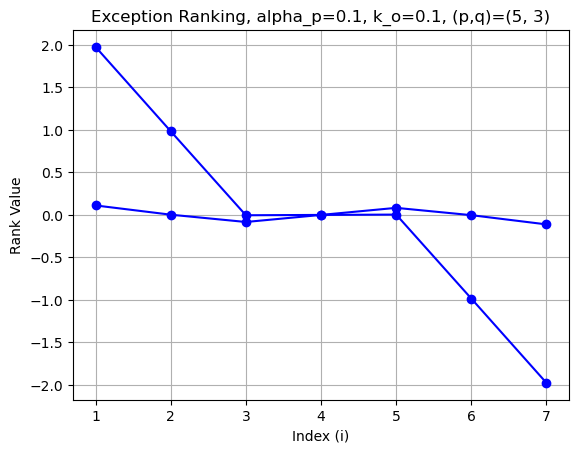

In [353]:
# Exception Ranking by formula
# rank_mult_exp(j): rank = alpha_prime * (b_i(j-1) - b_i(j) + c[1] * (delta(j,q) - delta(j,p)))

index = list(range(1,n+1))
rank_exp_vals = {}
rank_exp_vals_array = np.zeros(n)

for i in range(1, n+1):
   i_ind = i-1
   rank_exp_vals[f'{i}'] = rank_mult_exp_analytical(i) * -1
   print(rank_exp_vals[f'{i}'])
   rank_exp_vals_array[i_ind] = rank_exp_vals[f'{i}']

plt.plot(index, rank_exp_vals_array, marker='o', linestyle='-', color='b')
plt.title(f'Exception Ranking, alpha_p={alpha_prime}, k_o={k_o}, (p,q)={p,q}')
plt.xlabel('Index (i)')
plt.ylabel('Rank Value')
plt.grid(True)
plt.xticks(index)  # Set the ticks to match the index values

n = 7
k_o = .499
k_s = 1
alpha = 1 - (2 * (k_o/k_s))
alpha_prime = k_o/k_s
p = 5
q = 3
c_var = 0
lamb_val = np.arccosh((1+c_var)/(1-alpha))

index = list(range(1,n+1))
rank_exp_vals = {}
rank_exp_vals_array = np.zeros(n)

for i in range(1, n+1):
   i_ind = i-1
   rank_exp_vals[f'{i}'] = rank_mult_exp_analytical(i) * -1
   print(rank_exp_vals[f'{i}'])
   rank_exp_vals_array[i_ind] = rank_exp_vals[f'{i}']

plt.plot(index, rank_exp_vals_array, marker='o', linestyle='-', color='b')



In [354]:
def plot_exception():
   global rank_exp_vals, rank_exp_vals_array
   index = list(range(1,n+1))
   rank_exp_vals = {}
   rank_exp_vals_array = np.zeros(n)

   for i in range(1, n+1):
      i_ind = i-1
      rank_exp_vals[f'{i}'] = rank_mult_exp_analytical(i) * -1
      print(rank_exp_vals[f'{i}'])
      rank_exp_vals_array[i_ind] = rank_exp_vals[f'{i}']

   # plt.plot(index, rank_exp_vals_array, marker='o', linestyle='-', color='b')
   # plt.title(f'Exception Ranking, alpha_p={alpha_prime}, k_o={k_o}')
   # plt.xlabel('Index (i)')
   # plt.ylabel('Rank Value')
   # plt.grid(True)
   # plt.xticks(index)  # Set the ticks to match the index values
   # plt.show()
   return rank_exp_vals_array

In [355]:
print(rank_exp_vals_array)


[ 1.97626368  0.98418458 -0.0039499  -0.          0.0039499  -0.98418458
 -1.97626368]


In [356]:
i = 1
j = 1

print(create_D_ij_matrix())

D_test = create_D_ij_exp(i,j)
D_test_2 = D_ij_analytical_sol(i,j)
D_test_form = -2 * (1/2 - ( ( np.cosh((i-1/2) * lamb_val) * np.cosh( (n - (i-1/2)) * lamb_val ) * np.tanh(lamb_val/2) ) / (np.sinh(lamb_val * n)) ) )

print(D_test, D_test_2, D_test_form)


[[-0.84981649  0.14677743  0.14395964  0.14171884  0.14004605  0.13893457
   0.13837994]
 [ 0.14677743 -0.85263428  0.14453663  0.14228685  0.14060736  0.13949143
   0.13893457]
 [ 0.14395964  0.14453663 -0.85430707  0.14342515  0.14173222  0.14060736
   0.14004605]
 [ 0.14171884  0.14228685  0.14342515 -0.8548617   0.14342515  0.14228685
   0.14171884]
 [ 0.14004605  0.14060736  0.14173222  0.14342515 -0.85430707  0.14453663
   0.14395964]
 [ 0.13893457  0.13949143  0.14060736  0.14228685  0.14453663 -0.85263428
   0.14677743]
 [ 0.13837994  0.13893457  0.14004605  0.14171884  0.14395964  0.14677743
  -0.84981649]]
-0.849816488657412 -0.849816488657412 -0.8498164886574121


In [357]:

#D_pp
-1 + 2 * ( ( np.cosh((i-1/2) * lamb_val) * np.cosh( (n - (i-1/2)) * lamb_val ) * np.tanh(lamb_val/2) ) / (np.sinh(lamb_val * n)) ) 

#D_ij when i != j, doing this for q and p only
2 * ( np.cosh((q-1/2)*lamb_val) * np.cosh((n-(p-1/2))*lamb_val) * np.tanh(lamb_val/2) ) / np.sinh(n*lamb_val)

0.1417322245283514

In [358]:
D_pq = 2 * ( np.cosh((q-1/2)*lamb_val) * np.cosh((n-(p-1/2))*lamb_val) * np.tanh(lamb_val/2) ) / np.sinh(n*lamb_val)
assert np.isclose(D_ij(p,q), D_pq)

D_pp = -1 + 2 * ( ( np.cosh((p-1/2) * lamb_val) * np.cosh( (n - (p-1/2)) * lamb_val ) * np.tanh(lamb_val/2) ) / (np.sinh(lamb_val * n)) ) 
assert np.isclose(D_ij(p,p), D_pp)

D_qq = -1 + 2 * ( ( np.cosh((q-1/2) * lamb_val) * np.cosh( (n - (q-1/2)) * lamb_val ) * np.tanh(lamb_val/2) ) / (np.sinh(lamb_val * n)) ) 
assert np.isclose(D_ij(q,q), D_qq)

In [359]:


exp = D_ij(p,q) - D_ij(p,p) - D_ij(q,q) + D_ij(q,p)

exp_test1 = 2 + (4 * ( np.cosh((q-1/2)*lamb_val) * np.cosh((n-(p-1/2))*lamb_val) * np.tanh(lamb_val/2) ) / np.sinh(n*lamb_val)
                 - 2 * ( ( np.cosh((p-1/2) * lamb_val) * np.cosh( (n - (p-1/2)) * lamb_val ) * np.tanh(lamb_val/2) ) / (np.sinh(lamb_val * n)) ) 
                 - 2 *( ( np.cosh((q-1/2) * lamb_val) * np.cosh( (n - (q-1/2)) * lamb_val ) * np.tanh(lamb_val/2) ) / (np.sinh(lamb_val * n)) ) 
                 )

exp_test2 = ( 2 + ( np.tanh(lamb_val/2) / np.sinh(lamb_val * n) ) *
                ( 2 * (np.cosh((n-(p-1/2))*lamb_val)) * ( np.cosh((q-1/2)*lamb_val) - np.cosh((p-1/2) * lamb_val) )  + 
                ( 2 * (np.cosh((q-1/2)*lamb_val)) * ( np.cosh((n-(p-1/2)) * lamb_val) - np.cosh((n-(q-1/2))* lamb_val) ) ) 
                )
            ) 

exp_test3 = ( 2 + 4 * ( ( np.tanh(lamb_val/2) * np.sinh( ((q-p)/2) * lamb_val) ) / np.sinh(lamb_val * n)  *
              ( ( np.cosh((q - 1/2) * lamb_val) ) * ( np.sinh( (n-( (p+q)/2 - 1/2 ))*lamb_val ) ) +
                (np.cosh( (n-p+1/2) * lamb_val)) * (np.sinh( ( (p+q)/2 - 1/2 ) * lamb_val ) )
              )
                      )
            )



# 4 * ( ( np.tanh(lamb_val/2) * np.sinh((q-p)/2 * lamb_val) / np.sinh(lamb_val * n) ) * 
#                         ( np.cosh((q-1/2)*lamb_val) * np.sinh( (n - ((p+q-1)/2) ) * lamb_val ) 
#                         + np.cosh( (n-p+1/2) * lamb_val ) * np.sinh( ((p+1-1)/2) * lamb_val ) ) ) 
print(exp, exp_test1)
print(exp_test2)
print(exp_test3)
assert np.isclose(exp, exp_test1)
assert np.isclose(exp, exp_test2)


1.9920785857082237 1.992078585708224
1.992078585708224
1.992078585708224


In [360]:
print(lamb_val)

0.06329832592011325


In [361]:
exp_test3 = ( ( 2 + 4 * ( ( np.tanh(lamb_val/2) * np.sinh(((q-p)/2) * lamb_val) ) / np.sinh(lamb_val * n) ) )  *
                ( 2 * (np.cosh((n-(p-1/2))*lamb_val)) * ( np.cosh((q-1/2)*lamb_val) - np.cosh((p-1/2) * lamb_val) ) ) + 
                  2 * (np.cosh((q-1/2)*lamb_val)) * ( np.cosh((n-(p-1/2)) * lamb_val) - np.cosh((n-(q-1/2))* lamb_val) 
                )
            )

In [362]:
print(p,q)

5 3


In [363]:


D_ij(p,q) - D_ij(p,p) - D_ij(q,q) + D_ij(q,p)

print(-2 + ( 5 * (np.tanh(lamb_val/2) / np.sinh(lamb_val/2)) * (np.cosh((q-1/2)*lamb_val) * np.cosh((n-p+1/2)*lamb_val)) ) )  


3.123690996380388


In [364]:
(np.tanh(lamb_val/2) / np.sinh(lamb_val/2))


0.9994993741863969

In [365]:
print(-2 + ( 5 * (np.tanh(lamb_val/2) / np.sinh(lamb_val * n)) * (np.cosh((q-1/2)*lamb_val) * np.cosh((n-p+1/2)*lamb_val)) ) ) 

-1.6456694386791215


In [366]:
check_variables()

n:  7
alpha:  0.0020000000000000018
k_s:  1
k_o:  0.499
alpha_prime:  0.499
c_var 0
lamb_val 0.06329832592011325
a [ 1.12372304  1.23723042  1.24858116  1.24858116  1.23723042  1.12372304
 -1.12372304 -1.23723042 -1.24858116 -1.24858116 -1.23723042 -1.12372304]
a_exp [ 1.11425873  1.14258735  1.35387158  1.35387158  1.14258735  1.11425873
 -1.11425873 -1.14258735 -1.35387158 -1.35387158 -1.14258735 -1.11425873
  1.04225685 -1.04225685]
b {1: 1.1142587346553352, 2: 1.1425873465533523, 3: 1.3538715769593956, 4: 1.3538715769593956, 5: 1.1425873465533523, 6: 1.1142587346553352}
c {1: 1.042256846081209}


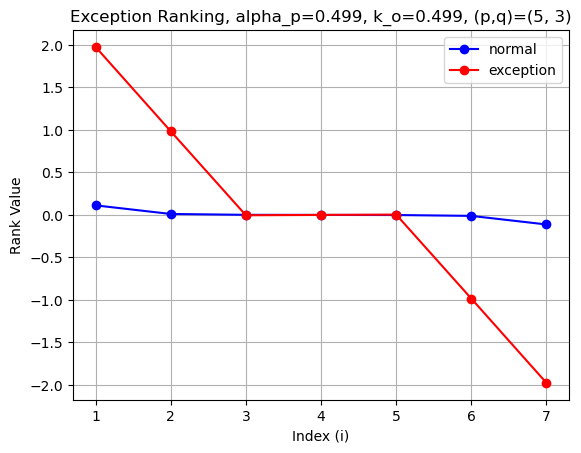

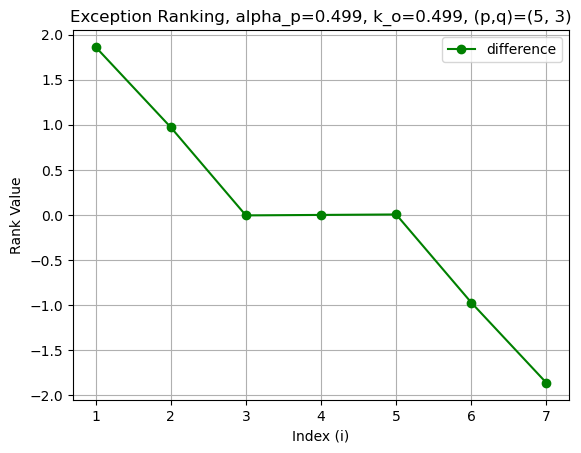

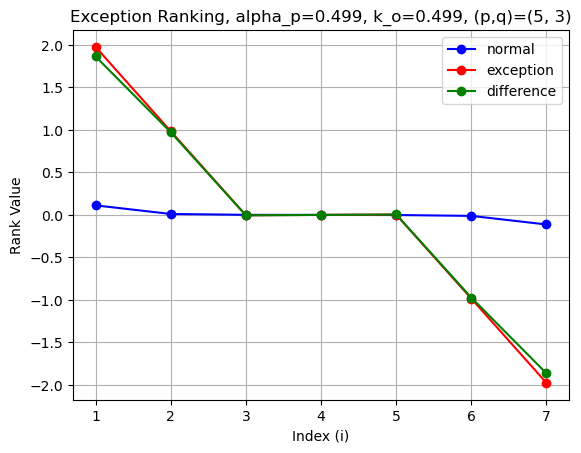

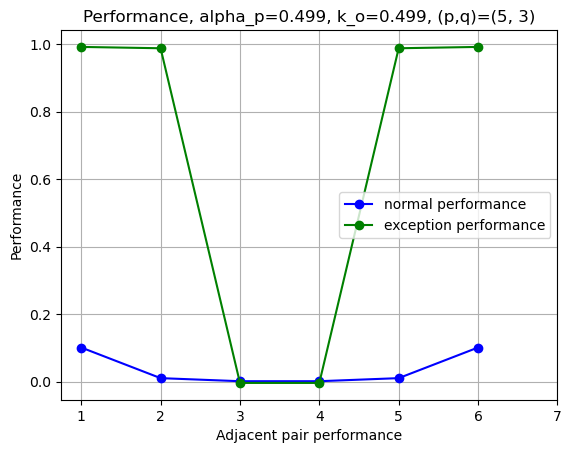

In [367]:
def plot_overlay():
   index = list(range(1,n+1))
   plt.plot(index, rank_vals_array, marker='o', linestyle='-', color='b', label='normal')
   plt.plot(index, rank_exp_vals_array, marker='o', linestyle='-', color='r', label='exception')
   plt.legend()
   plt.title(f'Exception Ranking, alpha_p={alpha_prime}, k_o={k_o}, (p,q)={p,q}')
   plt.xlabel('Index (i)')
   plt.ylabel('Rank Value')
   plt.grid(True)
   plt.xticks(index)  # Set the ticks to match the index values
   plt.show()
   return rank_exp_vals_array

plot_overlay()

def plot_difference():
   index = list(range(1,n+1))
   plt.plot(index, rank_exp_vals_array - rank_vals_array, marker='o', linestyle='-', color='g', label='difference')
   plt.legend()
   plt.title(f'Exception Ranking, alpha_p={alpha_prime}, k_o={k_o}, (p,q)={p,q}')
   plt.xlabel('Index (i)')
   plt.ylabel('Rank Value')
   plt.grid(True)
   plt.xticks(index)  # Set the ticks to match the index values
   plt.show()
   return rank_exp_vals_array

plot_difference()

def plot_overlay_diff():
   index = list(range(1,n+1))
   plt.plot(index, rank_vals_array, marker='o', linestyle='-', color='b', label='normal')
   plt.plot(index, rank_exp_vals_array, marker='o', linestyle='-', color='r', label='exception')
   plt.plot(index, rank_exp_vals_array - rank_vals_array, marker='o', linestyle='-', color='g', label='difference')
   plt.legend()
   plt.title(f'Exception Ranking, alpha_p={alpha_prime}, k_o={k_o}, (p,q)={p,q}')
   plt.xlabel('Index (i)')
   plt.ylabel('Rank Value')
   plt.grid(True)
   plt.xticks(index)  # Set the ticks to match the index values
   plt.show()
   return rank_exp_vals_array

#This is actually wrong so fix later
def plot_performance():
   index_perf = list(range(1,n))
   performance_normal = np.zeros(n-1)
   performance_exception = np.zeros(n-1)
   for i in range(0,n-1):
      performance_normal[i] = rank_vals_array[i] - rank_vals_array[i+1]
      performance_exception[i] = rank_exp_vals_array[i] - rank_exp_vals_array[i+1]
   plt.plot(index_perf, performance_normal, marker='o', linestyle='-', color='b', label='normal performance')
   plt.plot(index_perf, performance_exception, marker='o', linestyle='-', color='g', label='exception performance')
   plt.legend()
   plt.title(f'Performance, alpha_p={alpha_prime}, k_o={k_o}, (p,q)={p,q}')
   plt.xlabel('Adjacent pair performance')
   plt.ylabel('Performance')
   plt.grid(True)
   plt.xticks(index)  # Set the ticks to match the index values
   plt.show()

plot_overlay_diff()
plot_performance()

In [368]:
diff_1 = []

def diff(j):
    return c[1] * alpha_prime * (D_ij(j,q) - D_ij(j,p) + delta(j,q) - delta(j,p))

for j in range(1,n+1):
    print(diff(j))
    diff_1.append(diff(j))

D_ij_matrix_1 = create_D_ij_matrix()

print(create_D_ij_matrix())

def get_Djq_Djp():
    return create_D_ij_exp(j,q), create_D_ij_exp(j,p)

D_ij_interest_1 = np.ones(2)
D_ij_interest_1 = get_Djq_Djp()


0.002035402520030391
0.0020435604459623016
0.0020599089949241587
0.0
-0.0020599089949241587
-0.0020435604459622435
-0.002035402520030391
[[-0.84981649  0.14677743  0.14395964  0.14171884  0.14004605  0.13893457
   0.13837994]
 [ 0.14677743 -0.85263428  0.14453663  0.14228685  0.14060736  0.13949143
   0.13893457]
 [ 0.14395964  0.14453663 -0.85430707  0.14342515  0.14173222  0.14060736
   0.14004605]
 [ 0.14171884  0.14228685  0.14342515 -0.8548617   0.14342515  0.14228685
   0.14171884]
 [ 0.14004605  0.14060736  0.14173222  0.14342515 -0.85430707  0.14453663
   0.14395964]
 [ 0.13893457  0.13949143  0.14060736  0.14228685  0.14453663 -0.85263428
   0.14677743]
 [ 0.13837994  0.13893457  0.14004605  0.14171884  0.14395964  0.14677743
  -0.84981649]]


In [369]:
rank_exp_vals[f'{i}']

1.976263681779483

In [370]:
def set_variables(n_set, k_o_set, k_s_set, p_set, q_set, c_var_set):
    global n, k_o, k_s, alpha, alpha_prime, p, q, c_var, lamb_val
    global K, K_exp, A, arr_len, dual_len, dual_len_exp, a, a_exp, b, b_bar, c, c_bar
    
    n = n_set
    k_o = k_o_set
    k_s = k_s_set
    alpha = 1 - (2 * (k_o/k_s))
    alpha_prime = k_o/k_s
    p = p_set
    q = q_set
    c_var = c_var_set
    lamb_val = np.arccosh((1+c_var)/(1-alpha))

    K = {}
    K_exp = {}
    A = {}

    arr_len = n-1
    dual_len = (n-1) * 2
    dual_len_exp = (n-1)*2 + 2
    a = np.zeros(dual_len)
    a_exp = np.zeros(dual_len_exp)
    b = np.zeros(arr_len)
    b_bar = np.zeros(arr_len)
    c = np.zeros(1)
    c_bar = np.zeros(1) 

    index = list(range(1,n+1))



In [371]:

def run_simulation(n_set, k_o_set, k_s_set, p_set, q_set, c_var_set):
    global n, k_o, k_s, alpha, alpha_prime, p, q, c_var, lamb_val
    global K, K_exp, A, arr_len, dual_len, dual_len_exp, a, a_exp
    global b, b_bar, c, c_bar, y, y_exp, b_array, b_bar_array, c_array, c_bar_array, B, index

    set_variables(n_set, k_o_set, k_s_set, p_set, q_set, c_var_set)
    K = k_create(n,alpha_prime)
    # print('K', '\n', K)
    # print('det:', np.linalg.det(K))

    y = y_create(n)
    a = a_create(n, alpha_prime)
    K_exp = k_create_excep(n, p, q, alpha_prime)
    y_exp = y_create_exp(n)
    a_exp = a_exp_create(n, p, q, alpha_prime)
    b, b_bar, c, c_bar = create_bc(n,p,q,alpha_prime)
    b_array, b_bar_array, c_array, c_bar_array = create_bc_arrays(n,p,q,alpha_prime)

    A = tridiag(n)
    B = np.linalg.inv(np.identity(n-1) - (A*alpha_prime))
    # check_variables()
    # show_ranks_exp()
    c_analytical = c_double_til()
    assert np.isclose(c_analytical, c[1])
    plot_normal()
    plot_exception()
    plot_overlay()
    plot_difference()
    plot_overlay_diff()
    plot_performance()

    return rank_vals, rank_vals_array, rank_exp_vals, rank_exp_vals_array

def run_simulation_noplot(n_set, k_o_set, k_s_set, p_set, q_set, c_var_set):
    global n, k_o, k_s, alpha, alpha_prime, p, q, c_var, lamb_val
    global K, K_exp, A, arr_len, dual_len, dual_len_exp, a, a_exp
    global b, b_bar, c, c_bar, y, y_exp, b_array, b_bar_array, c_array, c_bar_array, B, index

    set_variables(n_set, k_o_set, k_s_set, p_set, q_set, c_var_set)
    K = k_create(n,alpha_prime)

    y = y_create(n)
    a = a_create(n, alpha_prime)
    K_exp = k_create_excep(n, p, q, alpha_prime)
    y_exp = y_create_exp(n)
    a_exp = a_exp_create(n, p, q, alpha_prime)
    b, b_bar, c, c_bar = create_bc(n,p,q,alpha_prime)
    b_array, b_bar_array, c_array, c_bar_array = create_bc_arrays(n,p,q,alpha_prime)

    A = tridiag(n)
    B = np.linalg.inv(np.identity(n-1) - (A*alpha_prime))
    c_analytical = c_double_til()
    assert np.isclose(c_analytical, c[1])

    return rank_vals, rank_vals_array, rank_exp_vals, rank_exp_vals_array



In [372]:
def run_simulation_output():
    global rank_exp_vals, rank_exp_vals_array
    index = list(range(1,n+1))
    rank_exp_vals = {}
    rank_exp_vals_array = np.zeros(n)

    for i in range(1, n+1):
        i_ind = i-1
        rank_exp_vals[f'{i}'] = rank_mult_exp_analytical(i) * -1
        # print(rank_exp_vals[f'{i}'])
        rank_exp_vals_array[i_ind] = rank_exp_vals[f'{i}']

def run_simulation_exp(n_set, k_o_set, k_s_set, p_set, q_set, c_var_set):
    global n, k_o, k_s, alpha, alpha_prime, p, q, c_var, lamb_val
    global K, K_exp, A, arr_len, dual_len, dual_len_exp, a, a_exp
    global b, b_bar, c, c_bar, y, y_exp, b_array, b_bar_array, c_array, c_bar_array, B, index

    index = list(range(1,n+1))
    set_variables(n_set, k_o_set, k_s_set, p_set, q_set, c_var_set)
    # check_variables()
    K = k_create(n,alpha_prime)
    # print('K', '\n', K)
    # print('det:', np.linalg.det(K))

    y = y_create(n)
    a = a_create(n, alpha_prime)
    K_exp = k_create_excep(n, p, q, alpha_prime)
    y_exp = y_create_exp(n)
    a_exp = a_exp_create(n, p, q, alpha_prime)
    b, b_bar, c, c_bar = create_bc(n,p,q,alpha_prime)
    b_array, b_bar_array, c_array, c_bar_array = create_bc_arrays(n,p,q,alpha_prime)

    A = tridiag(n)
    B = np.linalg.inv(np.identity(n-1) - (A*alpha_prime))
    # check_variables()
    # show_ranks_exp()
    c_analytical = c_double_til()
    assert np.isclose(c_analytical, c[1])

    run_simulation_output()
    return rank_exp_vals_array

In [373]:

#First set of critical pairs
def run_exp_critical_pairs(n_set, k_s_set, p_set, q_set, c_var_set):
    k_o_array = np.array([0.499, 0.49, 0.45, 0.35])
    margins_array = []
    margins_index = [0,1,2,3]
    margins_values = ['p vs q','p vs q-1','q vs p+1', 'q-1 vs p-1']

    ranks_array = []
    print(margins_values)
    for i in range(0, len(k_o_array)):
        val = run_simulation_exp(n_set, k_o_array[i], k_s_set, p_set, q_set, c_var_set)
        ranks_array.append(val)
        # print('val', val, 'k_o', k_o_array[i])
        
        margins = np.zeros(4)
        margin = rank_exp_vals_array[p-1] - rank_exp_vals_array[q-1]
        margins[0] = margin
        margin = rank_exp_vals_array[p-1] - rank_exp_vals_array[q-2]
        margins[1] = margin
        margin = rank_exp_vals_array[q-1] - rank_exp_vals_array[p]
        margins[2] = margin
        margin = rank_exp_vals_array[p] - rank_exp_vals_array[q-2]
        margins[3] = margin

        margins_array.append(margins.copy())
        print('margins', margins, 'for k_o = ', k_o_array[i])

    colors = ['r', 'g', 'b', 'y']
    for i in range(0, len(k_o_array)):
        plt.plot(index, ranks_array[i], marker='o', linestyle='-', color=colors[i], label=f'k_o={k_o_array[i]}')
    plt.legend()
    plt.title(f'Exception Ranking, n = {n_set}, p,q = ({p_set},{q_set})')
    plt.xlabel('Index (i)')
    plt.ylabel('Rank Value')
    plt.grid(True)
    plt.xticks(index)
    plt.show()

    for i in range(0, len(margins)):
        plt.plot(margins_values, margins_array[i], marker='o', linestyle='-', color=colors[i], label=f'k_o={k_o_array[i]}')
    plt.legend()
    plt.title(f'Exception Ranking margins, n = {n_set}, p,q = ({p_set},{q_set})')
    plt.xlabel('Index (i)')
    plt.ylabel('Margin')
    plt.grid(True)
    plt.xticks(margins_index)
    plt.show()
    

    return ranks_array
    

['p vs q', 'p vs q-1', 'q vs p+1', 'q-1 vs p-1']
margins [ 0.0078998  -0.98023468  0.98023468 -1.96836916] for k_o =  0.499
margins [ 0.07089193 -0.82132341  0.82132341 -1.71353875] for k_o =  0.49
margins [ 0.23775905 -0.3791847   0.3791847  -0.99612844] for k_o =  0.45
margins [ 0.34694814  0.01606241 -0.01606241 -0.31482331] for k_o =  0.35


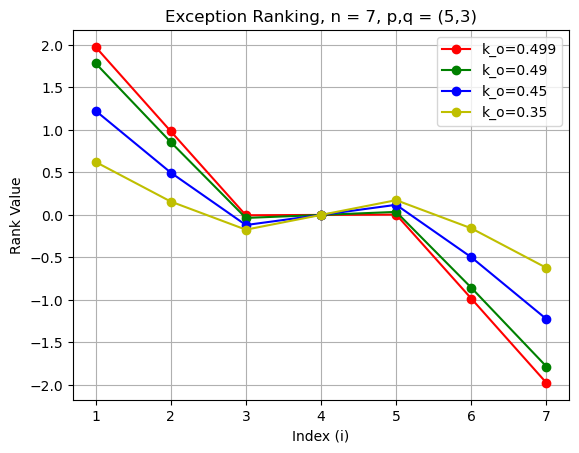

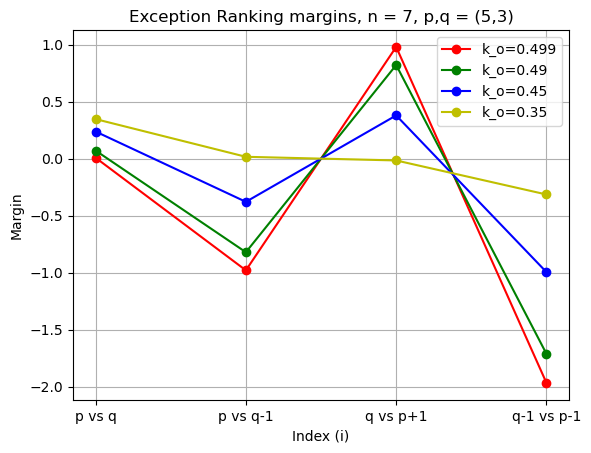

In [374]:
n_set = 7
k_s_set = 1
p_set = 5
q_set = 3
c_var_set = 0


vals = np.zeros((4,n))
vals = run_exp_critical_pairs(n_set, k_s_set, p_set, q_set, c_var_set)
# print('vals', vals)



['p vs q', 'p vs q-1', 'q vs p+1', 'q-1 vs p-1']
margins [ 0.01859269 -0.96041909  0.94654295 -1.92555472] for k_o =  0.499
margins [ 0.14425732 -0.68791877  0.58490657 -1.41708266] for k_o =  0.49
margins [ 0.34803681 -0.19347124 -0.01099678 -0.53051126] for k_o =  0.45
margins [ 0.39447472  0.08473181 -0.22576299 -0.08397992] for k_o =  0.35


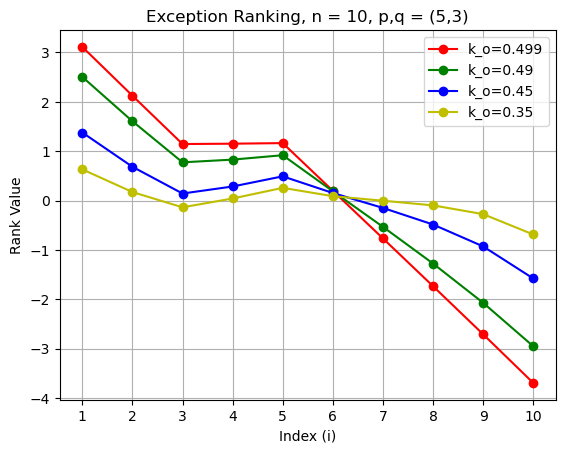

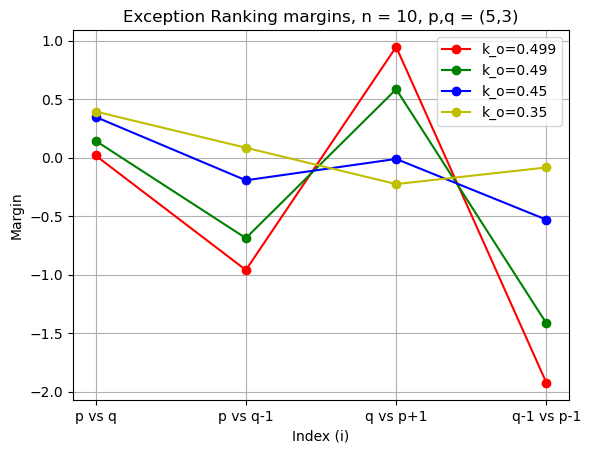

vals [array([ 3.11204444,  2.12451756,  1.14550579,  1.15249253,  1.16409848,
        0.19896284, -0.76537535, -1.73278118, -2.70713202, -3.69233309]), array([ 2.50472606,  1.60695978,  0.77478369,  0.82997411,  0.91904101,
        0.18987712, -0.53153668, -1.27464586, -2.06978141, -2.94939782]), array([ 1.37844621,  0.68476759,  0.14325955,  0.28555016,  0.49129636,
        0.15425633, -0.14850451, -0.48426635, -0.92764294, -1.57716241]), array([ 0.63185498,  0.17344496, -0.13629796,  0.04265758,  0.25817676,
        0.08946504, -0.00256238, -0.09678611, -0.27396936, -0.6859835 ])]


In [375]:
n_set = 10
k_s_set = 1
p_set = 5
q_set = 3
c_var_set = 0


vals = np.zeros((4,n))
vals = run_exp_critical_pairs(n_set, k_s_set, p_set, q_set, c_var_set)
print('vals', vals)


['p vs q', 'p vs q-1', 'q vs p+1', 'q-1 vs p-1']
margins [ 0.00318216 -0.99283218  0.99283218 -1.98884651] for k_o =  0.499
margins [ 0.03028201 -0.93109607  0.93109607 -1.89247415] for k_o =  0.49
margins [ 0.12309797 -0.70627458  0.70627458 -1.53564712] for k_o =  0.45
margins [ 0.23259034 -0.3595459   0.3595459  -0.95168213] for k_o =  0.35


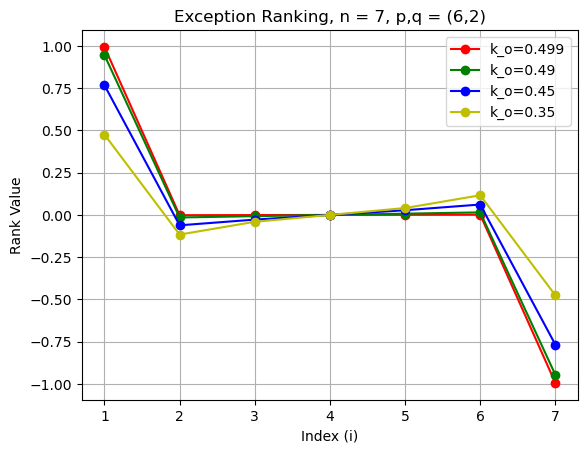

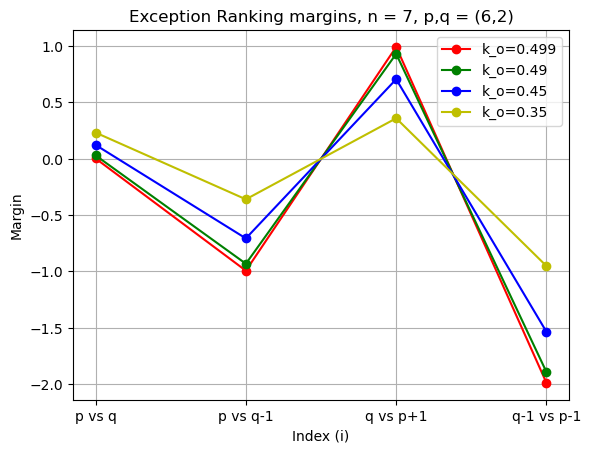

In [376]:
n_set = 7
k_s_set = 1
p_set = 6
q_set = 2
c_var_set = 0


vals = np.zeros((4,n))
vals = run_exp_critical_pairs(n_set, k_s_set, p_set, q_set, c_var_set)

['p vs q', 'p vs q-1', 'q vs p+1', 'q-1 vs p-1']
margins [ 0.01295963 -0.97956972  0.96204703 -1.95457639] for k_o =  0.499
margins [ 0.1062185  -0.82857354  0.68804559 -1.62283763] for k_o =  0.49
margins [ 0.28554758 -0.49124225  0.14606124 -0.92285107] for k_o =  0.45
margins [ 0.34866587 -0.21295153 -0.13310426 -0.42851313] for k_o =  0.35


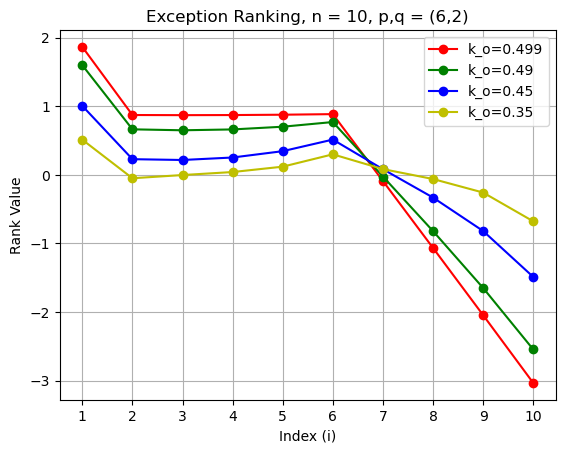

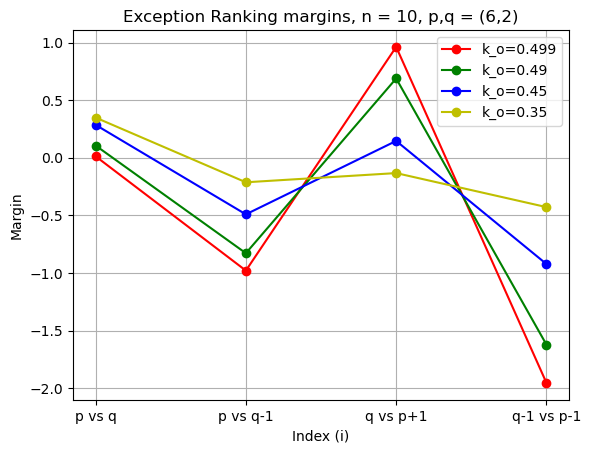

In [377]:
n_set = 10
k_s_set = 1
p_set = 6
q_set = 2
c_var_set = 0


vals = np.zeros((4,n))
vals = run_exp_critical_pairs(n_set, k_s_set, p_set, q_set, c_var_set)

['p vs q', 'p vs q-1', 'q vs p+1', 'q-1 vs p-1']
margins [ 0.00347651 -0.99253841  0.99253841 -1.98855333] for k_o =  0.499
margins [ 0.03276788 -0.92865894  0.92865894 -1.89008576] for k_o =  0.49
margins [ 0.12915425 -0.70076886  0.70076886 -1.53069198] for k_o =  0.45
margins [ 0.2358286  -0.35705492  0.35705492 -0.94993844] for k_o =  0.35


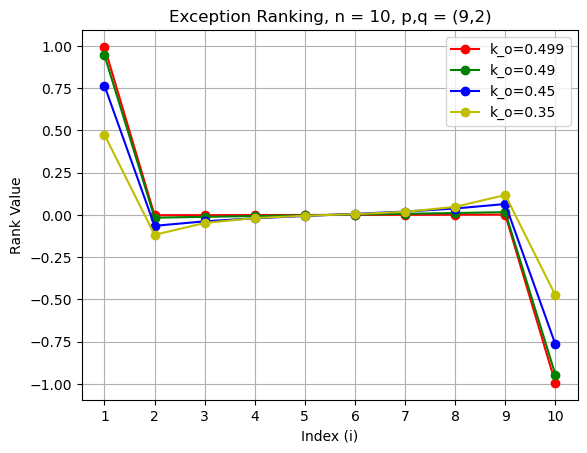

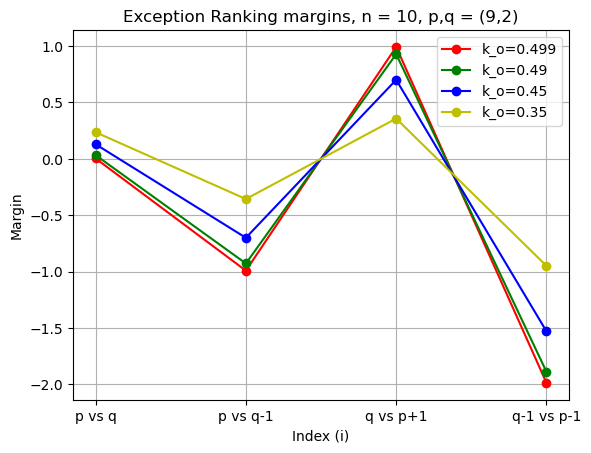

In [378]:
n_set = 10
k_s_set = 1
p_set = 9
q_set = 2
c_var_set = 0

vals = np.zeros((4,n))
vals = run_exp_critical_pairs(n_set, k_s_set, p_set, q_set, c_var_set)

In [379]:
def plot_c_alpha_prime(p_set_func, q_set_func):
    n_set = 7
    k_o_set = 0.50
    k_s_set = 1
    p_set = p_set_func
    q_set = q_set_func
    k_o_set_array = np.arange(0.499, 0, -0.05)
    c_var_set = 0

    c_vals_array = np.zeros(len(k_o_set_array))
    print(len(c_array))
    print(c[1])

    for i in range(0, len(k_o_set_array)):
        run_simulation_noplot(n_set, k_o_set_array[i], k_s_set, p_set, q_set, c_var_set)
        c_vals_array[i] = c[1]

    plt.plot(k_o_set_array, c_vals_array, marker='o', linestyle='-', color='b')
    print('(p,q): ', p_set, q_set)
    plt.title('k_o vs c')
    plt.xlabel('k_o')
    plt.ylabel('c')
    plt.grid(True)
    plt.xticks(k_o_set_array)
    plt.show

def plot_D_exp_alpha_prime(p_set_func, q_set_func):
    n_set = 7
    # k_o_set = 0.50
    k_s_set = 1
    p_set = p_set_func
    q_set = q_set_func
    c_var_set = 0

    k_o_set_array = np.arange(0.499, 0, -0.05)
    D_exp_array = np.zeros(len(k_o_set_array))
    for i in range(0, len(k_o_set_array)):
        run_simulation_noplot(n_set, k_o_set_array[i], k_s_set, p_set, q_set, c_var_set)
        D_exp_array[i] = k_o_set_array[i] * (D_ij(p,q) - D_ij(p,p) - D_ij(q,q) + D_ij(q,p))
    plt.plot(k_o_set_array, D_exp_array, marker='o', linestyle='-', color='b')
    print('(p,q): ', p_set, q_set)
    plt.title(f'k_o vs D_exp')
    plt.xlabel('k_o')
    plt.ylabel('D_exp')
    plt.grid(True)
    plt.xticks(k_o_set_array)
    plt.show

def plot_D_diff_alpha_prime(p_set_func, q_set_func):
    n_set = 7
    # k_o_set = 0.50
    k_s_set = 1
    p_set = p_set_func
    q_set = q_set_func
    c_var_set = 0

    k_o_set_array = np.arange(0.499, 0, -0.05)
    D_diff_array = np.zeros(len(k_o_set_array))

    j = 3

    for i in range(0, len(k_o_set_array)):
        run_simulation_noplot(n_set, k_o_set_array[i], k_s_set, p_set, q_set, c_var_set)
        D_diff_array[i] = D_ij_analytical_sol(j,q) - D_ij_analytical_sol(j,p)
    plt.plot(k_o_set_array, D_diff_array, marker='o', linestyle='-', color='b')
    print('(p,q): ', p_set, q_set)
    plt.title(f'k_o vs D_diff')
    plt.xlabel('k_o')
    plt.ylabel('D_exp')
    plt.grid(True)
    plt.xticks(k_o_set_array)
    plt.show

def plot_D_val_q_alpha_prime(p_set_func, q_set_func):
    n_set = 7
    # k_o_set = 0.50
    k_s_set = 1
    p_set = p_set_func
    q_set = q_set_func
    c_var_set = 0

    k_o_set_array = np.arange(0.499, 0, -0.05)
    D_val_array = np.zeros(len(k_o_set_array))

    j = 4

    for i in range(0, len(k_o_set_array)):
        run_simulation_noplot(n_set, k_o_set_array[i], k_s_set, p_set, q_set, c_var_set)
        D_val_array[i] = D_ij_analytical_sol(j,q)
    print(D_val_array)
    plt.plot(k_o_set_array, D_val_array, marker='o', linestyle='-', color='b')
    print('(p,q): ', p_set, q_set)
    plt.title(f'k_o vs D_val_jq')
    plt.xlabel('k_o')
    plt.ylabel('D_exp')
    plt.grid(True)
    plt.xticks(k_o_set_array)
    plt.show

def plot_D_val_p_alpha_prime(p_set_func, q_set_func):
    n_set = 7
    # k_o_set = 0.50
    k_s_set = 1
    p_set = p_set_func
    q_set = q_set_func
    c_var_set = 0

    k_o_set_array = np.arange(0.499, 0, -0.05)
    D_val_array = np.zeros(len(k_o_set_array))

    j = 3

    for i in range(0, len(k_o_set_array)):
        run_simulation_noplot(n_set, k_o_set_array[i], k_s_set, p_set, q_set, c_var_set)
        D_val_array[i] = D_ij_analytical_sol(j,p)
    plt.plot(k_o_set_array, D_val_array, marker='o', linestyle='-', color='b')
    print('(p,q): ', p_set, q_set)
    plt.title(f'k_o vs D_val_jp')
    plt.xlabel('k_o')
    plt.ylabel('D_exp')
    plt.grid(True)
    plt.xticks(k_o_set_array)
    plt.show

1
2.547237991898817
(p,q):  4 2
1
1.012035667419062
(p,q):  6 2
1
1.0143725936967378
(p,q):  3 2


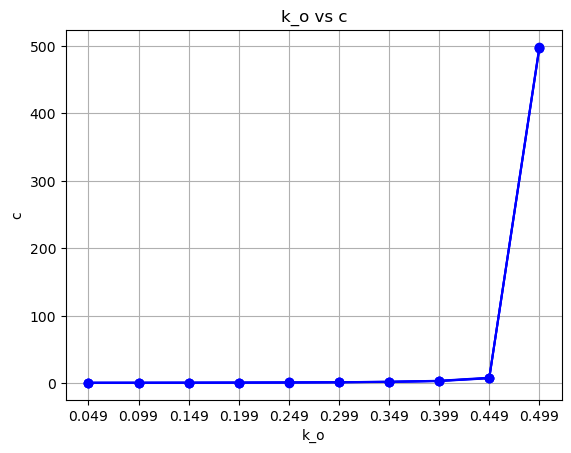

In [380]:
plot_c_alpha_prime(4,2)
plot_c_alpha_prime(6,2)
plot_c_alpha_prime(3,2)


(p,q):  4 2
(p,q):  6 2
(p,q):  3 2


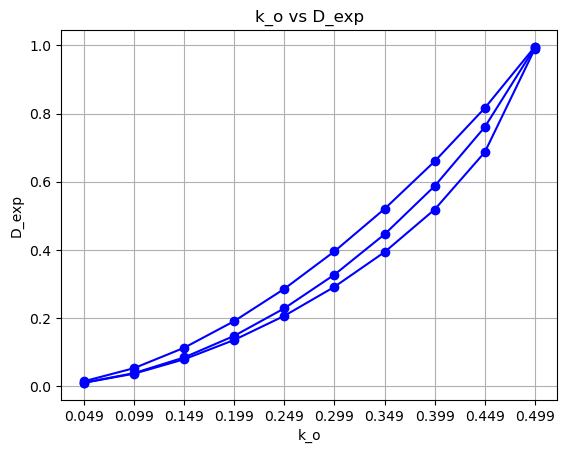

In [381]:
plot_D_exp_alpha_prime(4,2)
plot_D_exp_alpha_prime(6,2)
plot_D_exp_alpha_prime(3,2)

(p,q):  6 2
(p,q):  4 2
(p,q):  3 2


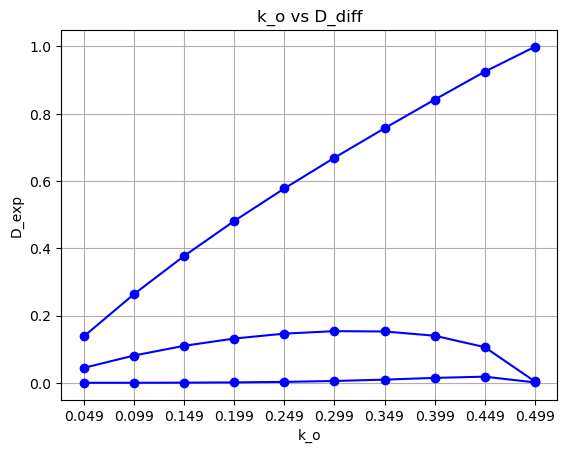

In [382]:
plot_D_diff_alpha_prime(6,2)
plot_D_diff_alpha_prime(4,2)
plot_D_diff_alpha_prime(3,2)

[1.41718842e-01 9.47564373e-02 6.24546730e-02 3.99933869e-02
 2.44460021e-02 1.39138510e-02 7.08739605e-03 3.00370370e-03
 8.99734863e-04 1.12681941e-04]
(p,q):  5 1
[0.14228685 0.1162824  0.09407333 0.07460084 0.0573132  0.04196507
 0.02852766 0.01715538 0.0081885  0.00218695]
(p,q):  5 2


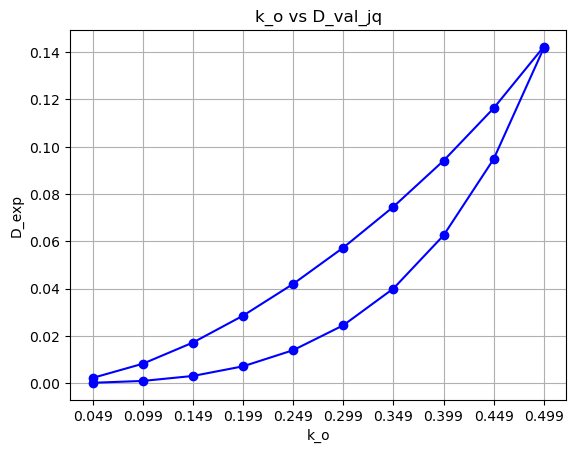

In [383]:
plot_D_val_q_alpha_prime(5,1)
plot_D_val_q_alpha_prime(5,2)

[0.14228685 0.1162824  0.09407333 0.07460084 0.0573132  0.04196507
 0.02852766 0.01715538 0.0081885  0.00218695]
(p,q):  3 2
[[-4.91182174e-02  4.67056181e-02  2.29409670e-03  1.12681941e-04
   5.53473763e-06  2.71888584e-07  1.40089807e-08]
 [ 4.67056181e-02 -9.35297388e-02  4.45242033e-02  2.18694950e-03
   1.07419091e-04  5.27685802e-06  2.71888584e-07]
 [ 2.29409670e-03  4.45242033e-02 -9.36368860e-02  4.45189405e-02
   2.18669162e-03  1.07419091e-04  5.53473763e-06]
 [ 1.12681941e-04  2.18694950e-03  4.45189405e-02 -9.36371438e-02
   4.45189405e-02  2.18694950e-03  1.12681941e-04]
 [ 5.53473763e-06  1.07419091e-04  2.18669162e-03  4.45189405e-02
  -9.36368860e-02  4.45242033e-02  2.29409670e-03]
 [ 2.71888584e-07  5.27685802e-06  1.07419091e-04  2.18694950e-03
   4.45242033e-02 -9.35297388e-02  4.67056181e-02]
 [ 1.40089807e-08  2.71888584e-07  5.53473763e-06  1.12681941e-04
   2.29409670e-03  4.67056181e-02 -4.91182174e-02]]


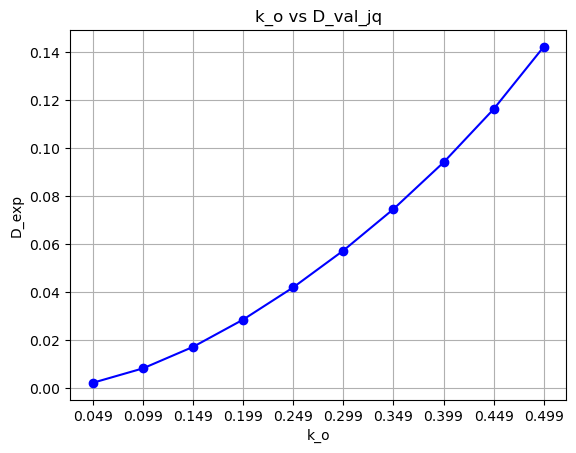

In [384]:

plot_D_val_q_alpha_prime(3,2)
print(create_D_ij_matrix())

In [385]:
import numpy as np

matrix = np.array([
    [-4.91182174e-02,  4.67056181e-02,  2.29409670e-03,  1.12681941e-04,  5.53473763e-06,  2.71888584e-07,  1.40089807e-08],
    [ 4.67056181e-02, -9.35297388e-02,  4.45242033e-02,  2.18694950e-03,  1.07419091e-04,  5.27685802e-06,  2.71888584e-07],
    [ 2.29409670e-03,  4.45242033e-02, -9.36368860e-02,  4.45189405e-02,  2.18669162e-03,  1.07419091e-04,  5.53473763e-06],
    [ 1.12681941e-04,  2.18694950e-03,  4.45189405e-02, -9.36371438e-02,  4.45189405e-02,  2.18694950e-03,  1.12681941e-04],
    [ 5.53473763e-06,  1.07419091e-04,  2.18669162e-03,  4.45189405e-02, -9.36368860e-02,  4.45242033e-02,  2.29409670e-03],
    [ 2.71888584e-07,  5.27685802e-06,  1.07419091e-04,  2.18694950e-03,  4.45242033e-02, -9.35297388e-02,  4.67056181e-02],
    [ 1.40089807e-08,  2.71888584e-07,  5.53473763e-06,  1.12681941e-04,  2.29409670e-03,  4.67056181e-02, -4.91182174e-02]
])

def format_matrix(matrix):
    formatted_matrix = ""
    for row in matrix:
        formatted_row = " ".join([f"{val: .8f}" for val in row])
        formatted_matrix += formatted_row + "\n"
    return formatted_matrix

formatted_matrix = format_matrix(matrix)
print(formatted_matrix)


-0.04911822  0.04670562  0.00229410  0.00011268  0.00000553  0.00000027  0.00000001
 0.04670562 -0.09352974  0.04452420  0.00218695  0.00010742  0.00000528  0.00000027
 0.00229410  0.04452420 -0.09363689  0.04451894  0.00218669  0.00010742  0.00000553
 0.00011268  0.00218695  0.04451894 -0.09363714  0.04451894  0.00218695  0.00011268
 0.00000553  0.00010742  0.00218669  0.04451894 -0.09363689  0.04452420  0.00229410
 0.00000027  0.00000528  0.00010742  0.00218695  0.04452420 -0.09352974  0.04670562
 0.00000001  0.00000027  0.00000553  0.00011268  0.00229410  0.04670562 -0.04911822



(p,q):  4 2
(p,q):  6 2
(p,q):  3 2


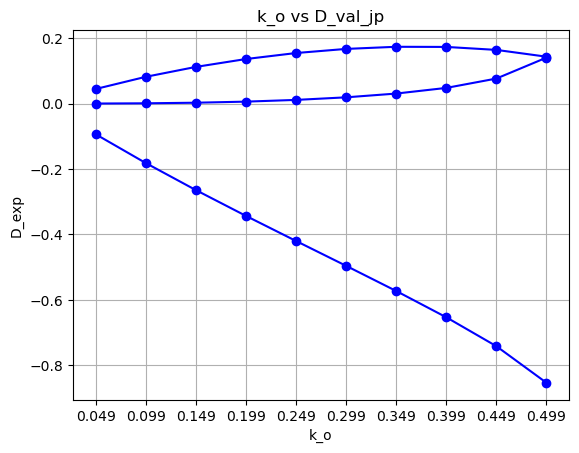

In [386]:
plot_D_val_p_alpha_prime(4,2)
plot_D_val_p_alpha_prime(6,2)
plot_D_val_p_alpha_prime(3,2)

0.9941520467836256
0.49122807017543846
0.23391812865497075
0.0935672514619883
0.0
-0.0935672514619883
-0.23391812865497075
-0.49122807017543846
-0.9941520467836256
0.9387755102040816
0.40816326530612246
0.08163265306122458
-0.20408163265306134
-0.0
0.20408163265306134
-0.08163265306122452
-0.40816326530612246
-0.9387755102040816


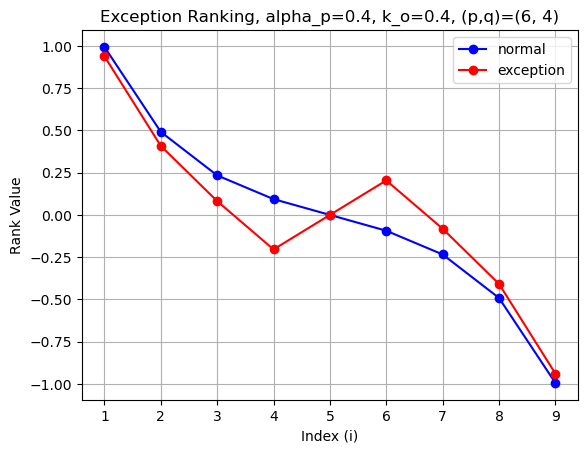

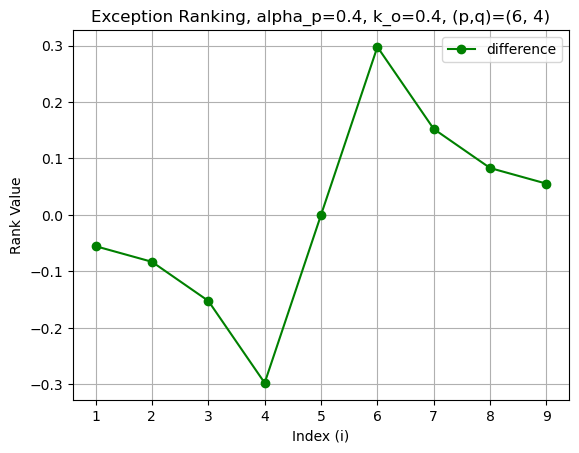

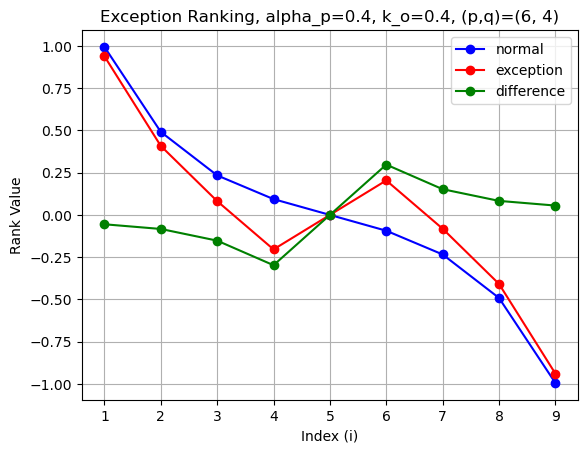

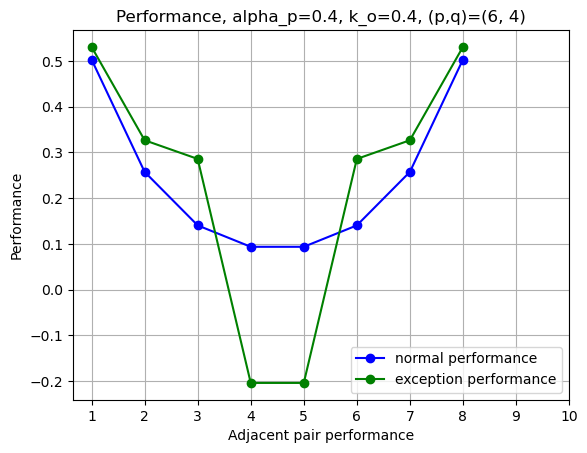

({'1': 0.9941520467836256,
  '2': 0.49122807017543846,
  '3': 0.23391812865497075,
  '4': 0.0935672514619883,
  '5': 0.0,
  '6': -0.0935672514619883,
  '7': -0.23391812865497075,
  '8': -0.49122807017543846,
  '9': -0.9941520467836256},
 array([ 0.99415205,  0.49122807,  0.23391813,  0.09356725,  0.        ,
        -0.09356725, -0.23391813, -0.49122807, -0.99415205]),
 {'1': 0.9387755102040816,
  '2': 0.40816326530612246,
  '3': 0.08163265306122458,
  '4': -0.20408163265306134,
  '5': -0.0,
  '6': 0.20408163265306134,
  '7': -0.08163265306122452,
  '8': -0.40816326530612246,
  '9': -0.9387755102040816},
 array([ 0.93877551,  0.40816327,  0.08163265, -0.20408163, -0.        ,
         0.20408163, -0.08163265, -0.40816327, -0.93877551]))

In [387]:
n_set = 9
k_o_set = 0.4
k_s_set = 1
p_set = 6
q_set = 4
c_var_set = 0

run_simulation(n_set, k_o_set, k_s_set, p_set, q_set, c_var_set)

In [388]:
len(rank_vals_array)

9

In [389]:
check_variables()

diff_2 = []

for j in range(1,n+1):
    print(diff(j))
    diff_2.append(diff(j))
    
print(diff_1)
print(diff_2)

D_ij_matrix_2 = create_D_ij_matrix()
print(D_ij_matrix_2)
print(D_ij_matrix_1)

D_ij_interest_2 = np.ones(2)
D_ij_interest_2 = get_Djq_Djp()

print(D_ij_interest_1)
print(D_ij_interest_2)


n:  9
alpha:  0.19999999999999996
k_s:  1
k_o:  0.4
alpha_prime:  0.4
c_var 0
lamb_val 0.6931471805599453
a [ 2.48538012  3.71345029  4.29824561  4.53216374  4.53216374  4.29824561
  3.71345029  2.48538012 -2.48538012 -3.71345029 -4.29824561 -4.53216374
 -4.53216374 -4.29824561 -3.71345029 -2.48538012]
a_exp [ 2.34693878  3.36734694  3.57142857  6.02040816  6.02040816  3.57142857
  3.36734694  2.34693878 -2.34693878 -3.36734694 -3.57142857 -6.02040816
 -6.02040816 -3.57142857 -3.36734694 -2.34693878  2.95918367 -2.95918367]
b {1: 2.3469387755102042, 2: 3.3673469387755106, 3: 3.571428571428572, 4: 6.020408163265307, 5: 6.020408163265308, 6: 3.571428571428572, 7: 3.367346938775511, 8: 2.3469387755102042}
c {1: 2.959183673469388}
0.05537653657954407
0.08306480486931603
0.15228547559374608
0.29764888411504964
0.0
-0.29764888411504964
-0.1522854755937462
-0.0830648048693161
-0.05537653657954407
[0.002035402520030391, 0.0020435604459623016, 0.0020599089949241587, 0.0, -0.0020599089949241587,

0.9767441860465114
0.46511627906976744
0.18604651162790697
0.0
-0.18604651162790697
-0.46511627906976744
-0.9767441860465114
0.6563391765185487
-0.015491235222176825
0.04011414594374221
0.11577660008153266
0.24932735426008962
-0.22763962494904189
-0.8184264166326943


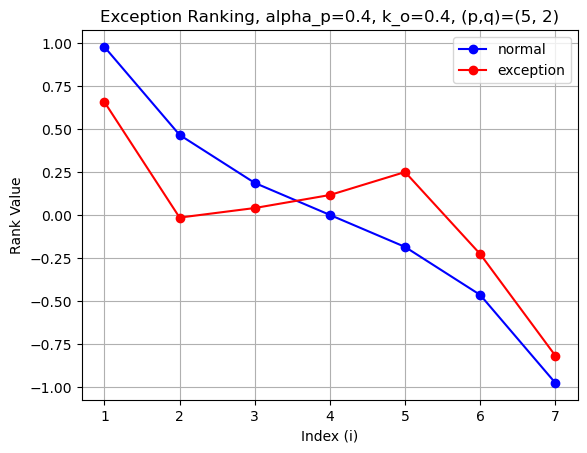

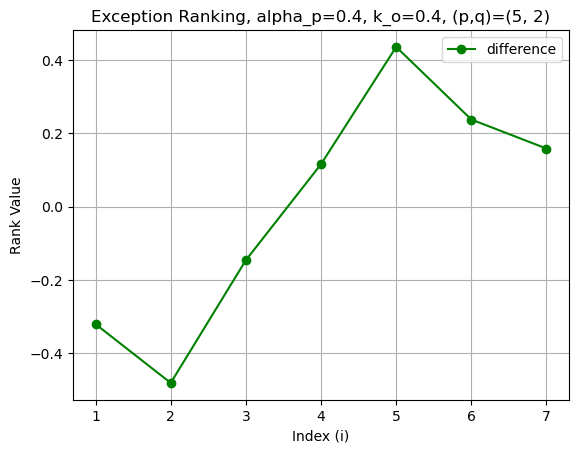

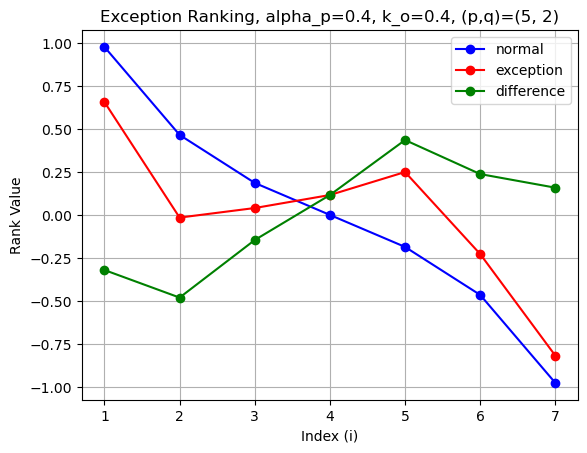

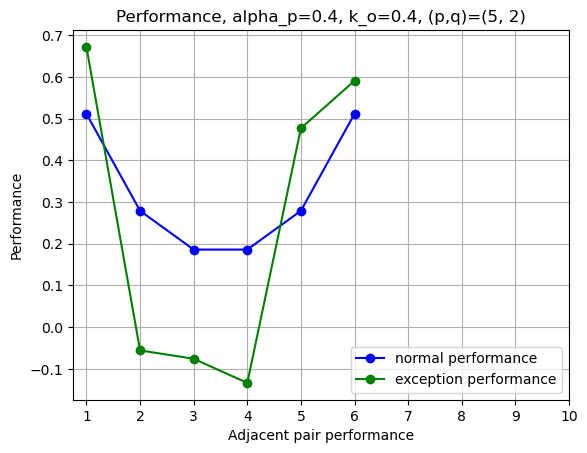

({'1': 0.9767441860465114,
  '2': 0.46511627906976744,
  '3': 0.18604651162790697,
  '4': 0.0,
  '5': -0.18604651162790697,
  '6': -0.46511627906976744,
  '7': -0.9767441860465114},
 array([ 0.97674419,  0.46511628,  0.18604651,  0.        , -0.18604651,
        -0.46511628, -0.97674419]),
 {'1': 0.6563391765185487,
  '2': -0.015491235222176825,
  '3': 0.04011414594374221,
  '4': 0.11577660008153266,
  '5': 0.24932735426008962,
  '6': -0.22763962494904189,
  '7': -0.8184264166326943},
 array([ 0.65633918, -0.01549124,  0.04011415,  0.1157766 ,  0.24932735,
        -0.22763962, -0.81842642]))

In [390]:
n_set = 7
k_o_set = 0.40
k_s_set = 1
p_set = 5
q_set = 2
c_var_set = 0

run_simulation(n_set, k_o_set, k_s_set, p_set, q_set, c_var_set)

0.9767441860465114
0.46511627906976744
0.18604651162790697
0.0
-0.18604651162790697
-0.46511627906976744
-0.9767441860465114
0.6563391765185487
-0.015491235222176825
0.04011414594374221
0.11577660008153266
0.24932735426008962
-0.22763962494904189
-0.8184264166326943


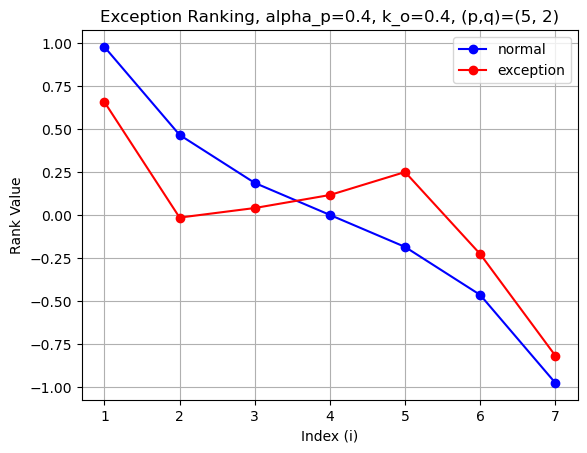

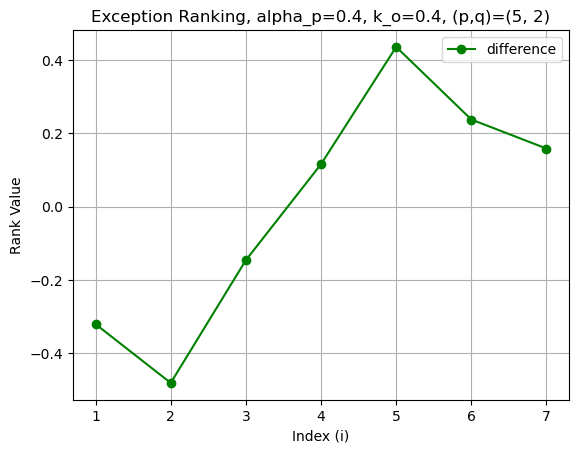

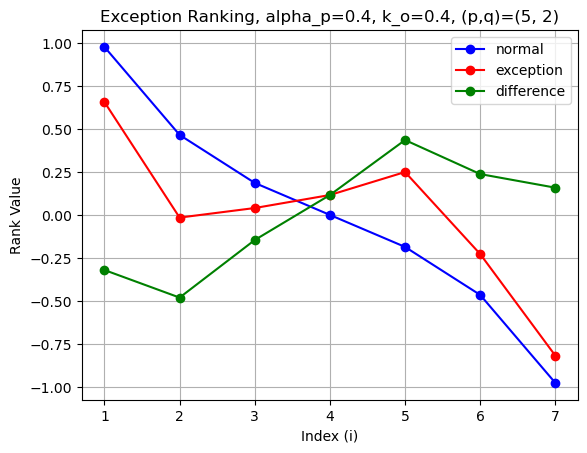

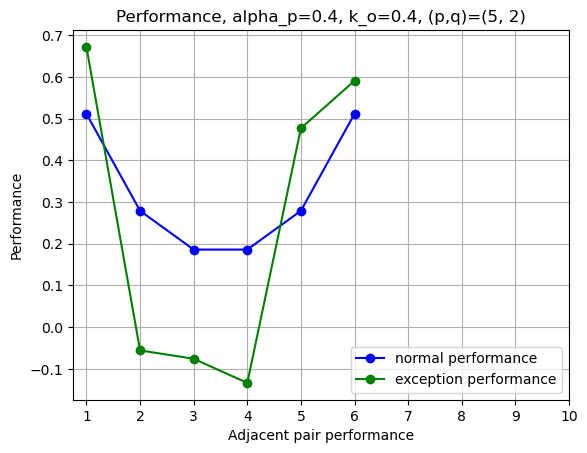

lamb_val 0.6931471805599453
c 3.6759070525886677


In [391]:
n_set = 7
k_o_set = 0.40
k_s_set = 1
p_set = 5
q_set = 2
c_var_set = 0

run_simulation(n_set, k_o_set, k_s_set, p_set, q_set, c_var_set)

print('lamb_val', lamb_val)
print('c', c[1])

0.11237230419977298
0.011350737797956865
0.0011350737797956867
0.0
-0.0011350737797956867
-0.011350737797956865
-0.11237230419977298
0.10283607388120991
-0.07447533506911072
-0.006668181103325369
0.007793524035857209
0.08460342146189734
-0.00268055288587553
-0.11140895032065283


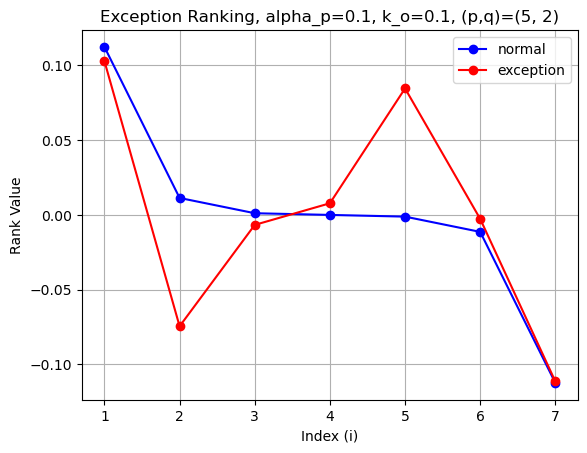

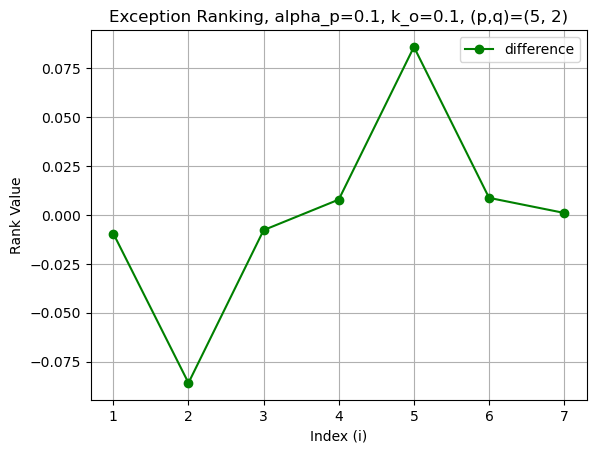

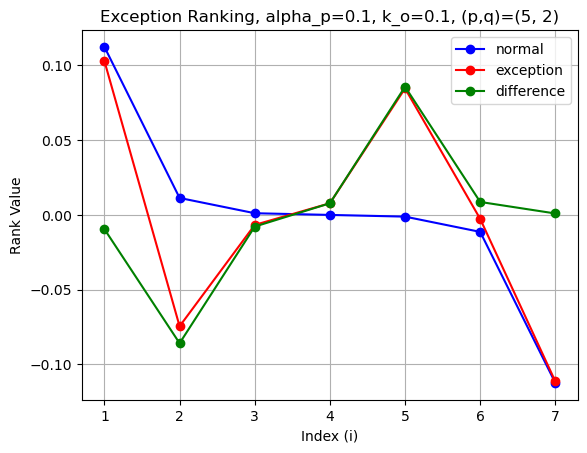

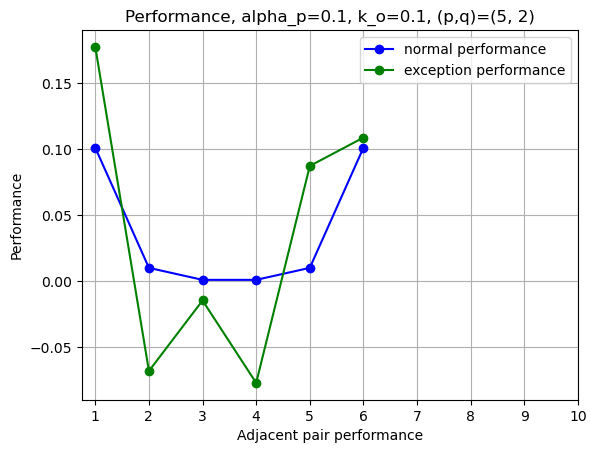

({'1': 0.11237230419977298,
  '2': 0.011350737797956865,
  '3': 0.0011350737797956867,
  '4': 0.0,
  '5': -0.0011350737797956867,
  '6': -0.011350737797956865,
  '7': -0.11237230419977298},
 array([ 0.1123723 ,  0.01135074,  0.00113507,  0.        , -0.00113507,
        -0.01135074, -0.1123723 ]),
 {'1': 0.10283607388120991,
  '2': -0.07447533506911072,
  '3': -0.006668181103325369,
  '4': 0.007793524035857209,
  '5': 0.08460342146189734,
  '6': -0.00268055288587553,
  '7': -0.11140895032065283},
 array([ 0.10283607, -0.07447534, -0.00666818,  0.00779352,  0.08460342,
        -0.00268055, -0.11140895]))

In [392]:
n_set = 7
k_o_set = 0.10
k_s_set = 1
p_set = 5
q_set = 2
c_var_set = 0

run_simulation(n_set, k_o_set, k_s_set, p_set, q_set, c_var_set)

0.9941520467836256
0.49122807017543846
0.23391812865497075
0.0935672514619883
0.0
-0.0935672514619883
-0.23391812865497075
-0.49122807017543846
-0.9941520467836256
0.9387755102040816
0.40816326530612246
0.08163265306122458
-0.20408163265306134
-0.0
0.20408163265306134
-0.08163265306122452
-0.40816326530612246
-0.9387755102040816


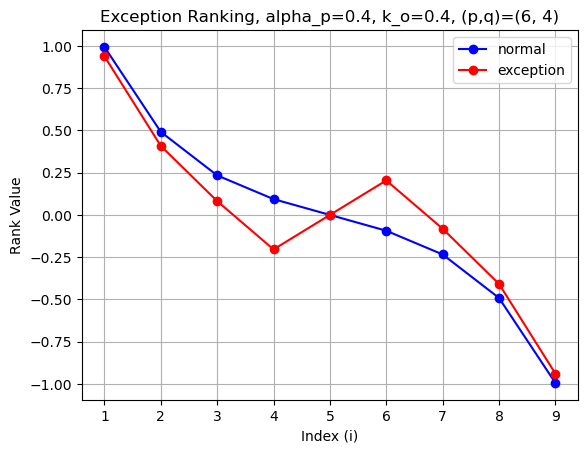

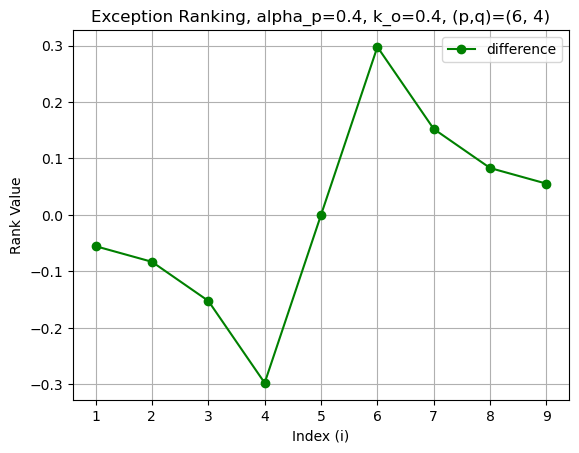

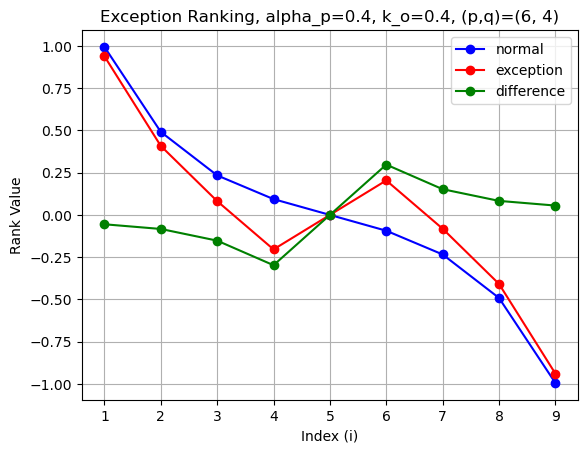

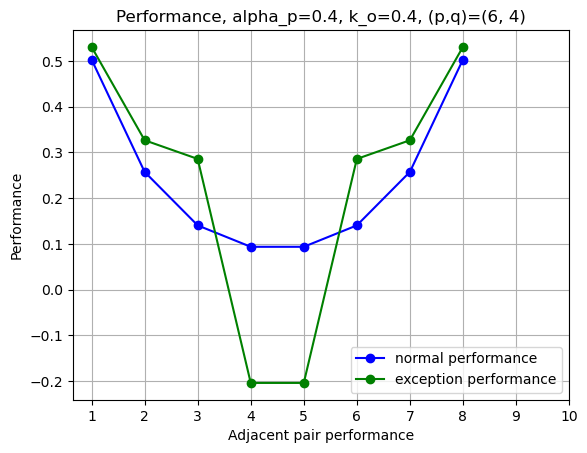

({'1': 0.9941520467836256,
  '2': 0.49122807017543846,
  '3': 0.23391812865497075,
  '4': 0.0935672514619883,
  '5': 0.0,
  '6': -0.0935672514619883,
  '7': -0.23391812865497075,
  '8': -0.49122807017543846,
  '9': -0.9941520467836256},
 array([ 0.99415205,  0.49122807,  0.23391813,  0.09356725,  0.        ,
        -0.09356725, -0.23391813, -0.49122807, -0.99415205]),
 {'1': 0.9387755102040816,
  '2': 0.40816326530612246,
  '3': 0.08163265306122458,
  '4': -0.20408163265306134,
  '5': -0.0,
  '6': 0.20408163265306134,
  '7': -0.08163265306122452,
  '8': -0.40816326530612246,
  '9': -0.9387755102040816},
 array([ 0.93877551,  0.40816327,  0.08163265, -0.20408163, -0.        ,
         0.20408163, -0.08163265, -0.40816327, -0.93877551]))

In [393]:
n_set = 9
k_o_set = 0.40
k_s_set = 1
p_set = 6
q_set = 4
c_var_set = 0

run_simulation(n_set, k_o_set, k_s_set, p_set, q_set, c_var_set)

0.6857382082054144
0.27351381523862683
0.0957298353335194
0.0
-0.0957298353335194
-0.27351381523862683
-0.6857382082054144
0.5011726888987251
-0.06925072061665372
0.004147627902708839
0.08110108605296383
0.22756976082004582
-0.13408128798756352
-0.6106591550702265


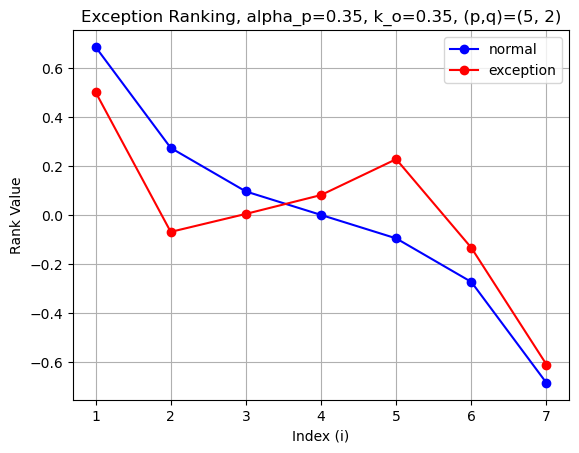

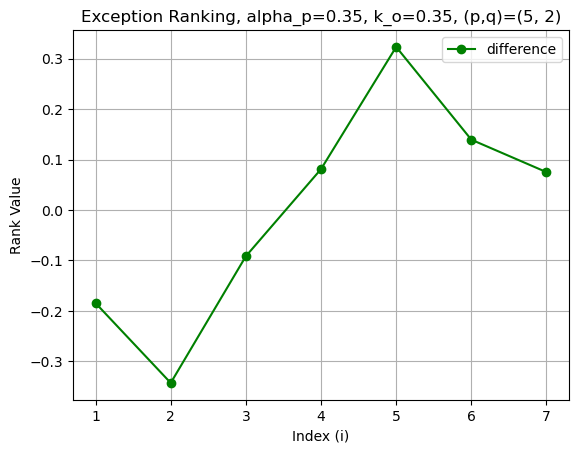

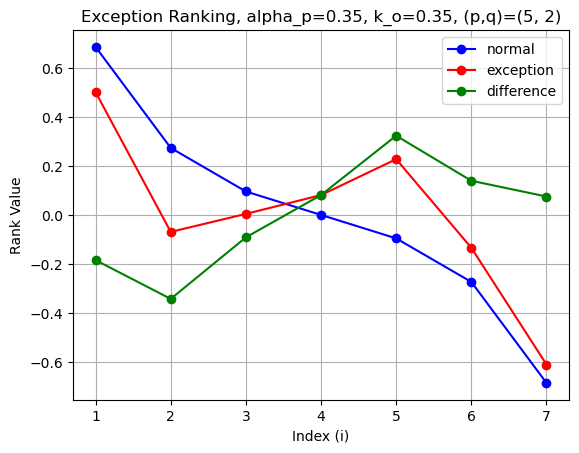

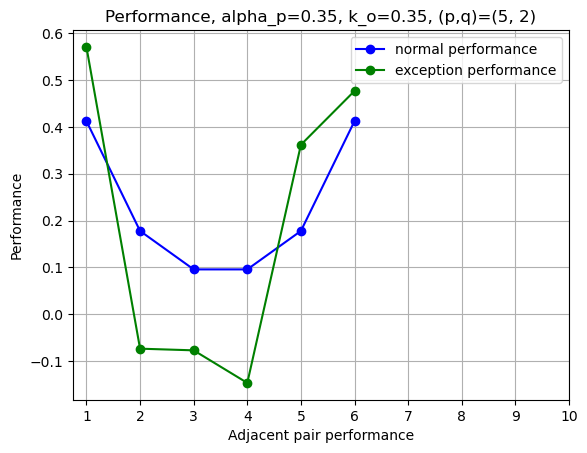

({'1': 0.6857382082054144,
  '2': 0.27351381523862683,
  '3': 0.0957298353335194,
  '4': 0.0,
  '5': -0.0957298353335194,
  '6': -0.27351381523862683,
  '7': -0.6857382082054144},
 array([ 0.68573821,  0.27351382,  0.09572984,  0.        , -0.09572984,
        -0.27351382, -0.68573821]),
 {'1': 0.5011726888987251,
  '2': -0.06925072061665372,
  '3': 0.004147627902708839,
  '4': 0.08110108605296383,
  '5': 0.22756976082004582,
  '6': -0.13408128798756352,
  '7': -0.6106591550702265},
 array([ 0.50117269, -0.06925072,  0.00414763,  0.08110109,  0.22756976,
        -0.13408129, -0.61065916]))

In [394]:
n_set = 7
k_o_set = 0.35
k_s_set = 1
p_set = 5
q_set = 2
c_var_set = 0

run_simulation(n_set, k_o_set, k_s_set, p_set, q_set, c_var_set)

In [395]:
( rank_exp_vals[f'{3}'] + rank_exp_vals[f'{4}'] ) / 2

0.042624356977836335

0.2637362637362637
0.054945054945054965
0.010989010989010995
0.0
-0.010989010989010995
-0.054945054945054965
-0.2637362637362637
0.22320198401763566
-0.10719206392945713
-0.016092587489666597
0.02672912648112429
0.14973821989528793
-0.021107743179939367
-0.2552769357949848


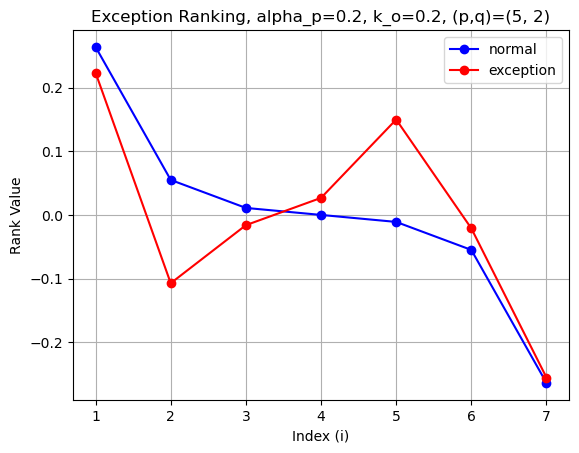

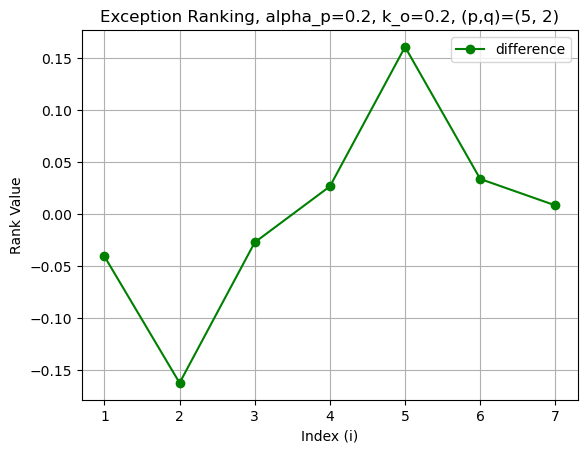

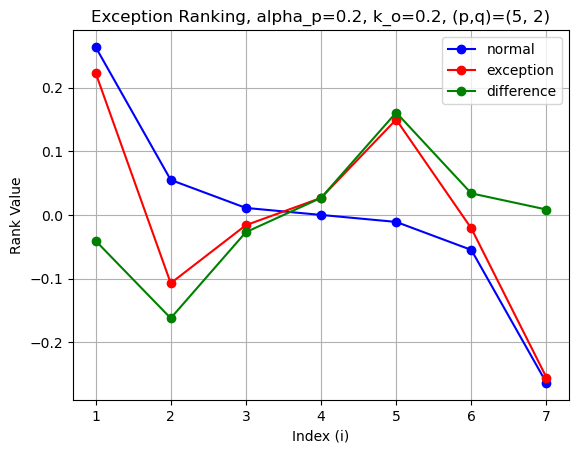

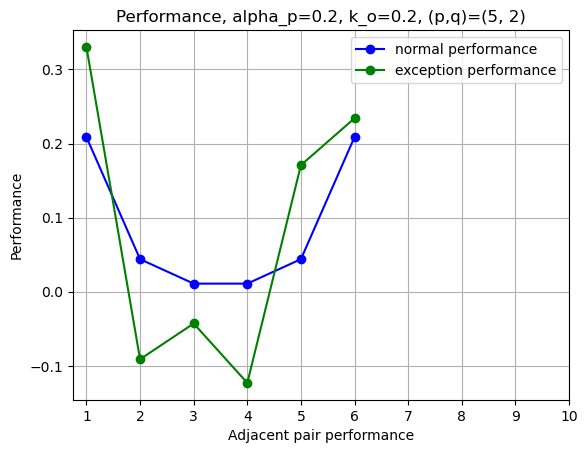

({'1': 0.2637362637362637,
  '2': 0.054945054945054965,
  '3': 0.010989010989010995,
  '4': 0.0,
  '5': -0.010989010989010995,
  '6': -0.054945054945054965,
  '7': -0.2637362637362637},
 array([ 0.26373626,  0.05494505,  0.01098901,  0.        , -0.01098901,
        -0.05494505, -0.26373626]),
 {'1': 0.22320198401763566,
  '2': -0.10719206392945713,
  '3': -0.016092587489666597,
  '4': 0.02672912648112429,
  '5': 0.14973821989528793,
  '6': -0.021107743179939367,
  '7': -0.2552769357949848},
 array([ 0.22320198, -0.10719206, -0.01609259,  0.02672913,  0.14973822,
        -0.02110774, -0.25527694]))

In [396]:
n_set = 7
k_o_set = 0.2
k_s_set = 1
p_set = 5
q_set = 2
c_var_set = 0

run_simulation(n_set, k_o_set, k_s_set, p_set, q_set, c_var_set)


0.11237230419977298
0.011350737797956865
0.0011350737797956867
0.0
-0.0011350737797956867
-0.011350737797956865
-0.11237230419977298
0.10283607388120991
-0.07447533506911072
-0.006668181103325369
0.007793524035857209
0.08460342146189734
-0.00268055288587553
-0.11140895032065283


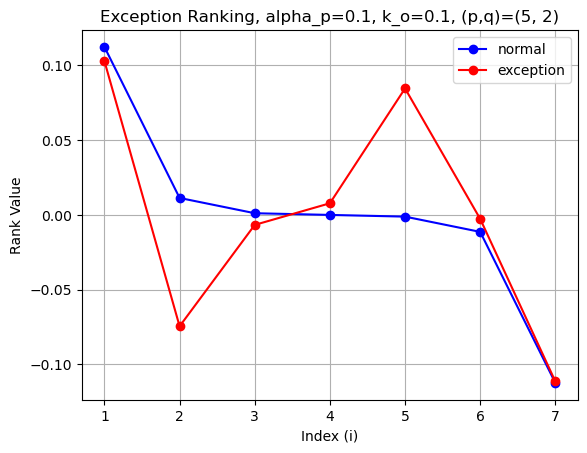

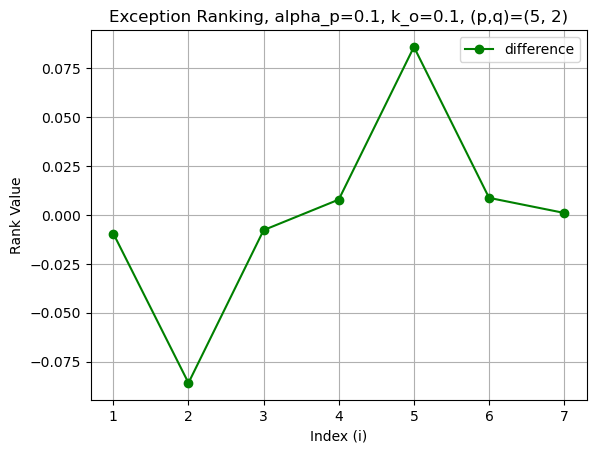

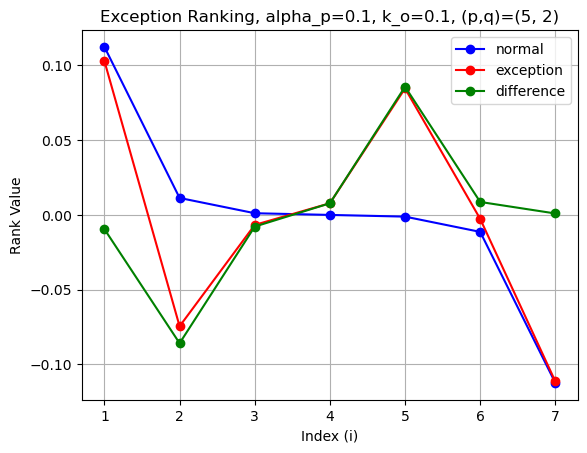

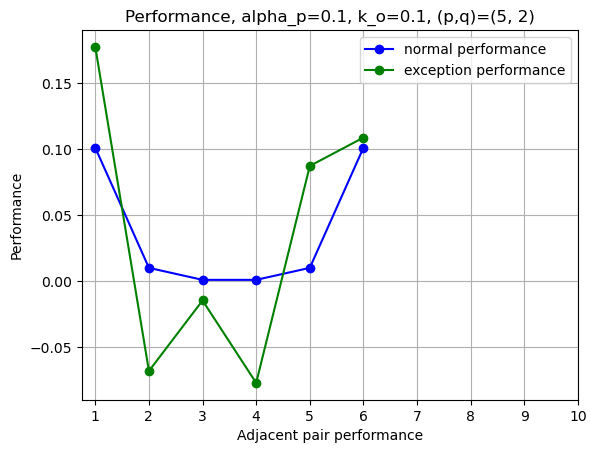

({'1': 0.11237230419977298,
  '2': 0.011350737797956865,
  '3': 0.0011350737797956867,
  '4': 0.0,
  '5': -0.0011350737797956867,
  '6': -0.011350737797956865,
  '7': -0.11237230419977298},
 array([ 0.1123723 ,  0.01135074,  0.00113507,  0.        , -0.00113507,
        -0.01135074, -0.1123723 ]),
 {'1': 0.10283607388120991,
  '2': -0.07447533506911072,
  '3': -0.006668181103325369,
  '4': 0.007793524035857209,
  '5': 0.08460342146189734,
  '6': -0.00268055288587553,
  '7': -0.11140895032065283},
 array([ 0.10283607, -0.07447534, -0.00666818,  0.00779352,  0.08460342,
        -0.00268055, -0.11140895]))

: 

In [397]:
n_set = 7
k_o_set = 0.1
k_s_set = 1
p_set = 5
q_set = 2
c_var_set = 0

run_simulation(n_set, k_o_set, k_s_set, p_set, q_set, c_var_set)
